In [1]:
import pandas as pd
from IPython.display import Image #type: ignore
from Utils import plot_ts
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsforecast import StatsForecast
from statsforecast.models import (
    Naive,
    SeasonalNaive,
    SeasonalWindowAverage,
    WindowAverage,
    RandomWalkWithDrift,
    HistoricAverage,
    AutoARIMA,
    AutoETS,
    AutoCES,
    AutoTheta,
    SimpleExponentialSmoothing,
    SimpleExponentialSmoothingOptimized,
    SeasonalExponentialSmoothing,
    SeasonalExponentialSmoothingOptimized,
    Holt,
    HoltWinters,
    ADIDA,
    CrostonClassic,
    CrostonOptimized,
    CrostonSBA,
    IMAPA,
    TSB,
    MSTL,
    DynamicOptimizedTheta,
    GARCH,
    ARCH
)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore

In [2]:
display(Image(url="Data/Tech_challenge_2.png", width=800, height=500))

- Carregar base

In [3]:
df = pd.read_csv('Data/Dados Históricos - Ibovespa.csv')
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,09.03.2023,105.071,106.540,106.724,105.053,"19,17M","-1,38%"
1,08.03.2023,106.540,104.228,106.721,104.228,"15,90M","2,22%"
2,07.03.2023,104.228,104.700,105.179,103.480,"12,58M","-0,45%"
3,06.03.2023,104.700,103.865,105.171,103.170,"14,28M","0,80%"
4,03.03.2023,103.866,103.326,104.440,103.323,"13,10M","0,52%"


- Tratar valores

In [4]:
df.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

In [5]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4999 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      4999 non-null   object 
 1   Último    4999 non-null   float64
 2   Abertura  4999 non-null   float64
 3   Máxima    4999 non-null   float64
 4   Mínima    4999 non-null   float64
 5   Vol.      4999 non-null   object 
 6   Var%      4999 non-null   object 
dtypes: float64(4), object(3)
memory usage: 312.4+ KB


In [6]:
def convert_volume(volume_str):
    volume_str = volume_str.replace(',', '.')
    if 'M' in volume_str:
        return int(float(volume_str.replace('M', '')) * 1_000_000)
    elif 'K' in volume_str:
        return int(float(volume_str.replace('K', '')) * 1_000)
    else:
        return int(volume_str)

df['Vol.'] = df['Vol.'].apply(convert_volume)
df['Var%'] = df['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y')
df.sort_values(by='Data', inplace=True)
df['ds'] = df['Data']
df['y'] = df['Último']
df.reset_index(drop=True, inplace=True)
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,ds,y
0,2003-01-02,11.603,11.291,11.603,11.291,195130000,2.97,2003-01-02,11.603
1,2003-01-03,11.600,11.632,11.798,11.600,197050000,-0.02,2003-01-03,11.600
2,2003-01-06,12.020,11.636,12.032,11.633,398400000,3.62,2003-01-06,12.020
3,2003-01-07,11.876,12.010,12.018,11.842,387980000,-1.19,2003-01-07,11.876
4,2003-01-08,11.786,11.875,11.928,11.757,217190000,-0.76,2003-01-08,11.786


In [7]:
print("Data mais antiga:", df['Data'].min())
print("Data mais recente:", df['Data'].max())

Data mais antiga: 2003-01-02 00:00:00
Data mais recente: 2023-03-09 00:00:00


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      4999 non-null   datetime64[ns]
 1   Último    4999 non-null   float64       
 2   Abertura  4999 non-null   float64       
 3   Máxima    4999 non-null   float64       
 4   Mínima    4999 non-null   float64       
 5   Vol.      4999 non-null   int64         
 6   Var%      4999 non-null   float64       
 7   ds        4999 non-null   datetime64[ns]
 8   y         4999 non-null   float64       
dtypes: datetime64[ns](2), float64(6), int64(1)
memory usage: 351.6 KB


- Ajustar campo **Data** e **index**

In [9]:
df.set_index(df.Data, inplace=True)
df.drop('Data', inplace=True, axis=1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4999 entries, 2003-01-02 to 2023-03-09
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Último    4999 non-null   float64       
 1   Abertura  4999 non-null   float64       
 2   Máxima    4999 non-null   float64       
 3   Mínima    4999 non-null   float64       
 4   Vol.      4999 non-null   int64         
 5   Var%      4999 non-null   float64       
 6   ds        4999 non-null   datetime64[ns]
 7   y         4999 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 351.5 KB


- análise

In [11]:
sns.set_style('darkgrid')

In [12]:
df.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,ds,y
Data,,,,,,,,
2003-01-02,11.603,11.291,11.603,11.291,195130000,2.97,2003-01-02,11.603
2003-01-03,11.600,11.632,11.798,11.600,197050000,-0.02,2003-01-03,11.600
2003-01-06,12.020,11.636,12.032,11.633,398400000,3.62,2003-01-06,12.020
2003-01-07,11.876,12.010,12.018,11.842,387980000,-1.19,2003-01-07,11.876
2003-01-08,11.786,11.875,11.928,11.757,217190000,-0.76,2003-01-08,11.786


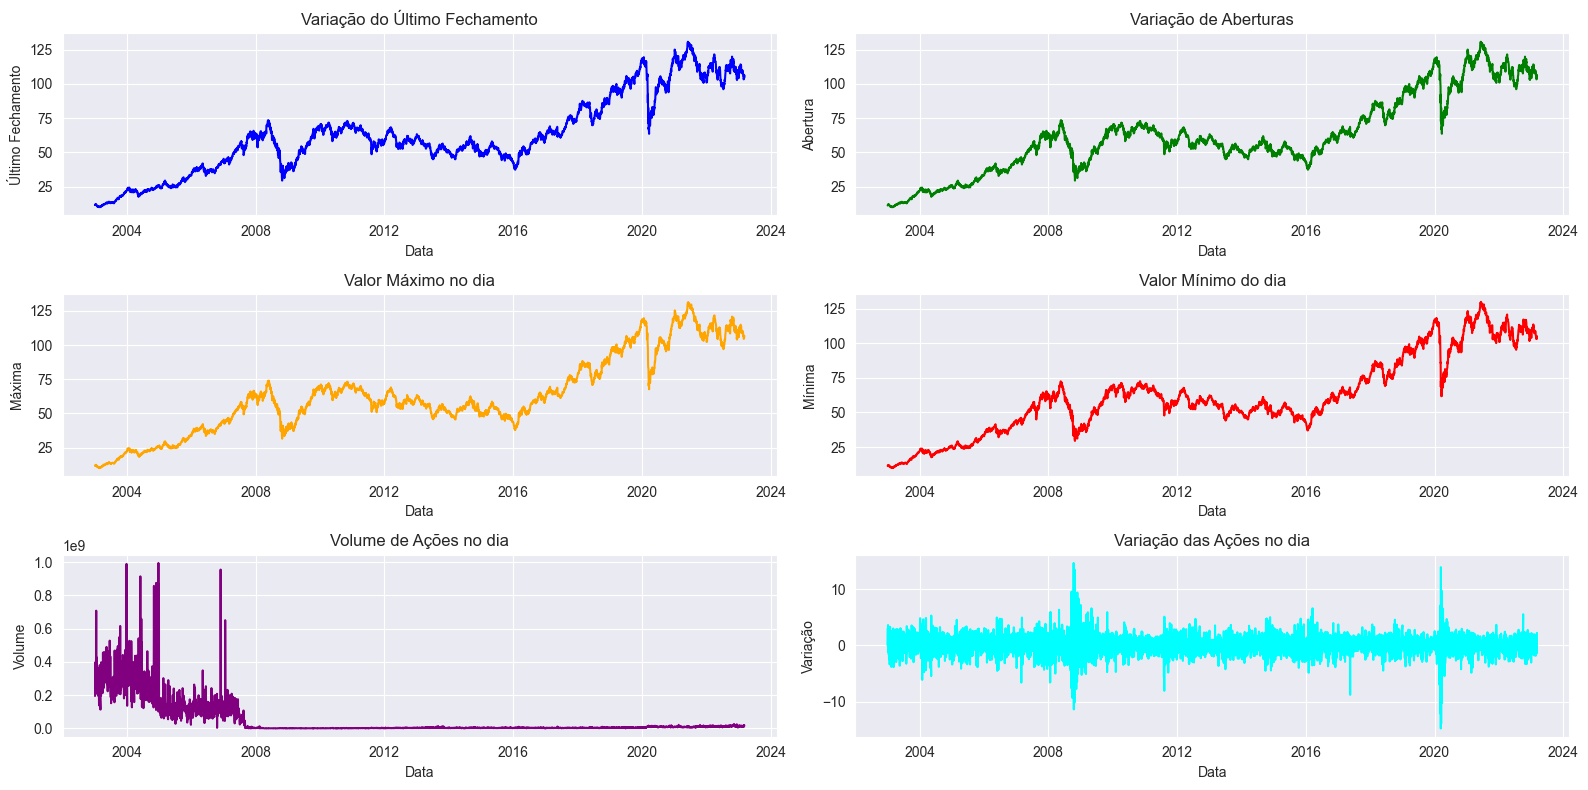

In [13]:
plot_ts(df)

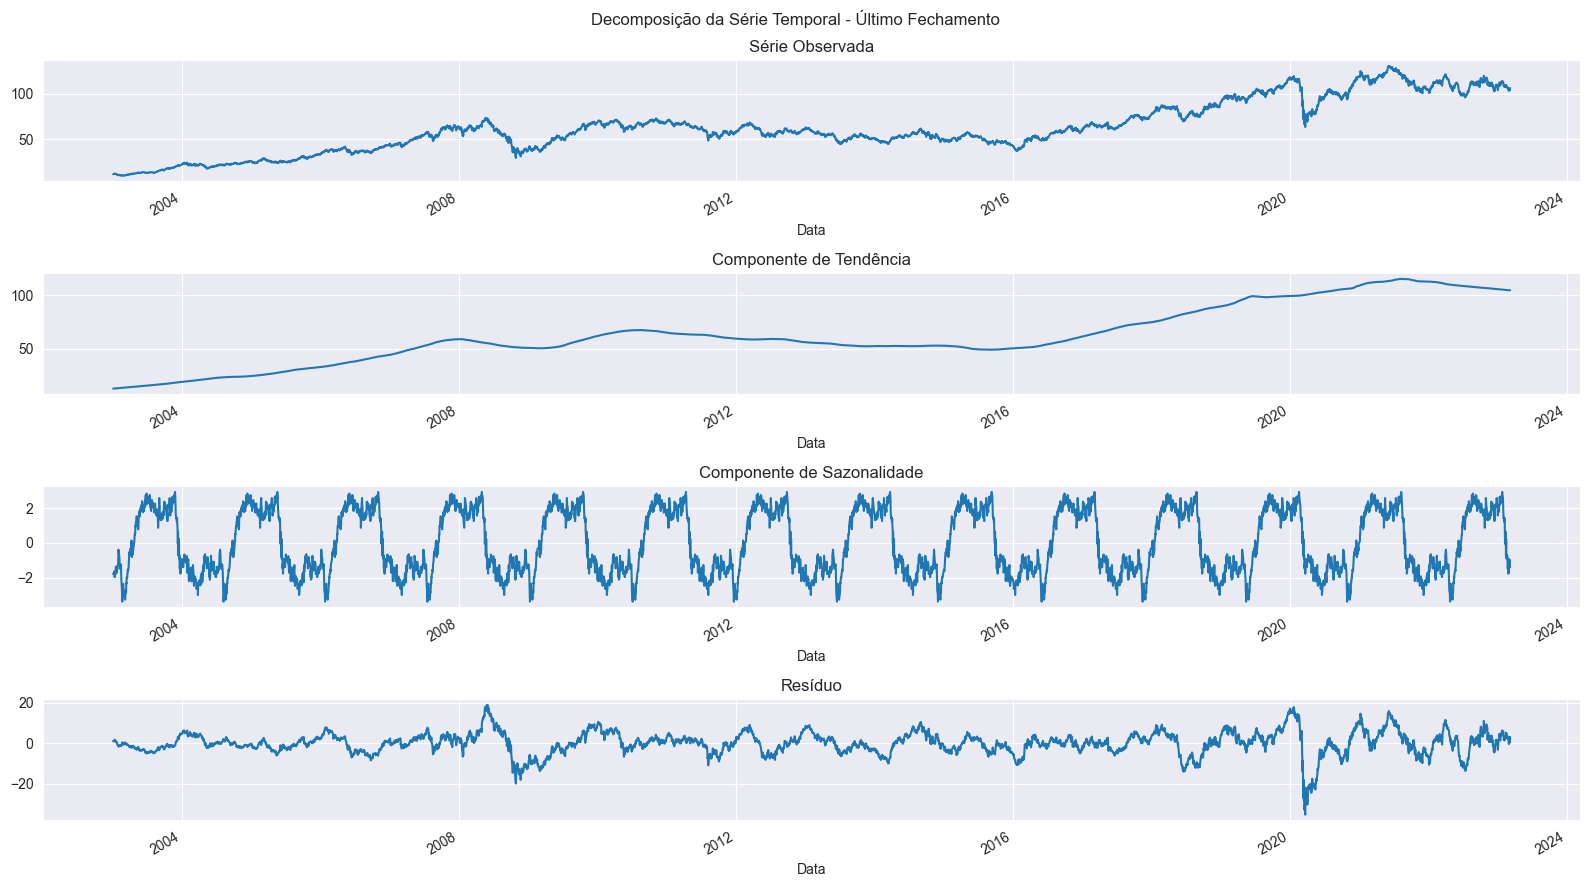

In [14]:
resultados = seasonal_decompose(df['Último'], model='additive', period=365, two_sided=True, extrapolate_trend=5) # Valor que estou supondo para uma sazonalidade
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 9))
resultados.observed.plot(ax=ax1)
ax1.set_xlabel('Data')
ax1.set_title('Série Observada')
resultados.trend.plot(ax=ax2)
ax2.set_xlabel('Data')
ax2.set_title('Componente de Tendência')
resultados.seasonal.plot(ax=ax3)
ax3.set_xlabel('Data')
ax3.set_title('Componente de Sazonalidade')
resultados.resid.plot(ax=ax4)
ax4.set_xlabel('Data')
ax4.set_title('Resíduo')
plt.suptitle('Decomposição da Série Temporal - Último Fechamento', fontsize=12)
plt.tight_layout()
plt.show()

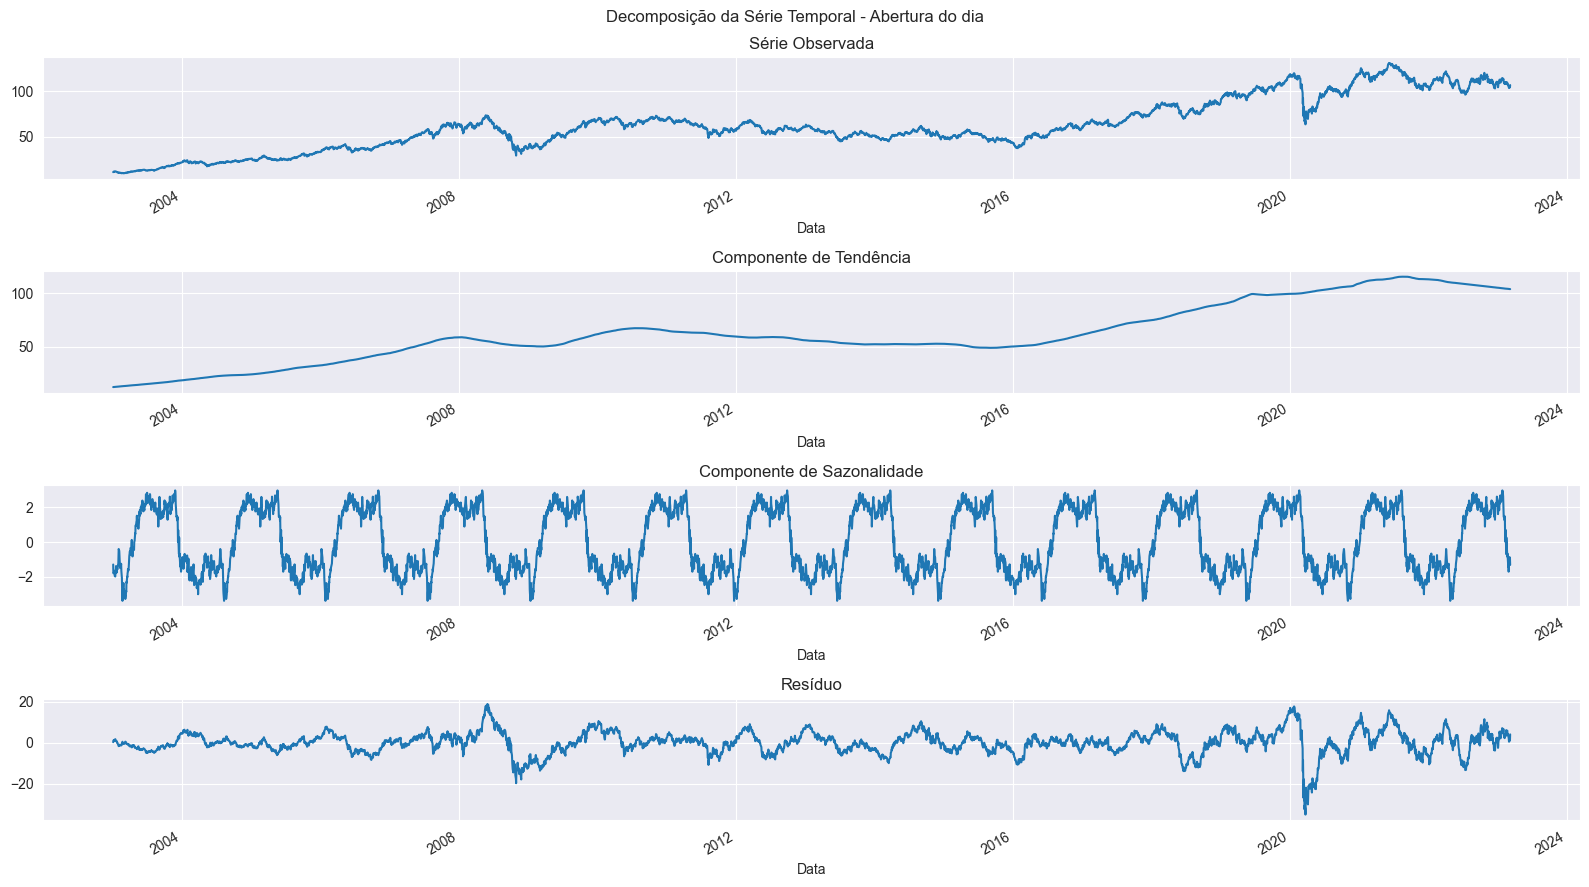

In [15]:
resultados = seasonal_decompose(df['Abertura'], model='additive', period=365, two_sided=True, extrapolate_trend=5)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 9))
resultados.observed.plot(ax=ax1)
ax1.set_xlabel('Data')
ax1.set_title('Série Observada')
resultados.trend.plot(ax=ax2)
ax2.set_xlabel('Data')
ax2.set_title('Componente de Tendência')
resultados.seasonal.plot(ax=ax3)
ax3.set_xlabel('Data')
ax3.set_title('Componente de Sazonalidade')
resultados.resid.plot(ax=ax4)
ax4.set_xlabel('Data')
ax4.set_title('Resíduo')
plt.suptitle('Decomposição da Série Temporal - Abertura do dia', fontsize=12)
plt.tight_layout()
plt.show()

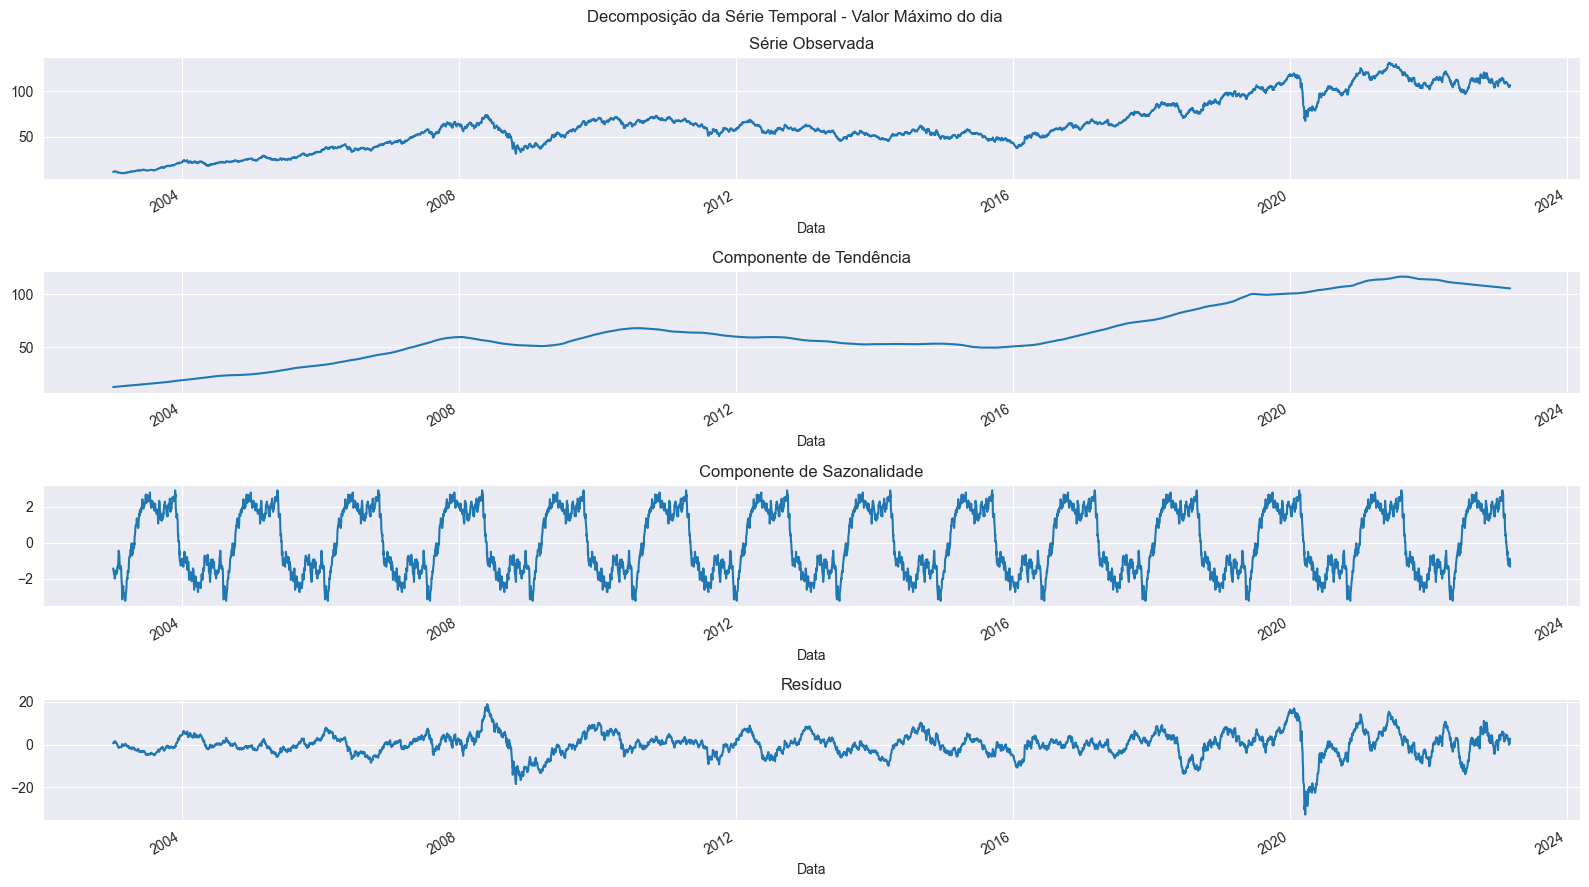

In [16]:
resultados = seasonal_decompose(df['Máxima'], model='additive', period=365, two_sided=True, extrapolate_trend=5)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 9))
resultados.observed.plot(ax=ax1)
ax1.set_title('Série Observada')
resultados.trend.plot(ax=ax2)
ax2.set_title('Componente de Tendência')
resultados.seasonal.plot(ax=ax3)
ax3.set_title('Componente de Sazonalidade')
resultados.resid.plot(ax=ax4)
ax4.set_title('Resíduo')
plt.suptitle('Decomposição da Série Temporal - Valor Máximo do dia', fontsize=12)
plt.tight_layout()
plt.show()

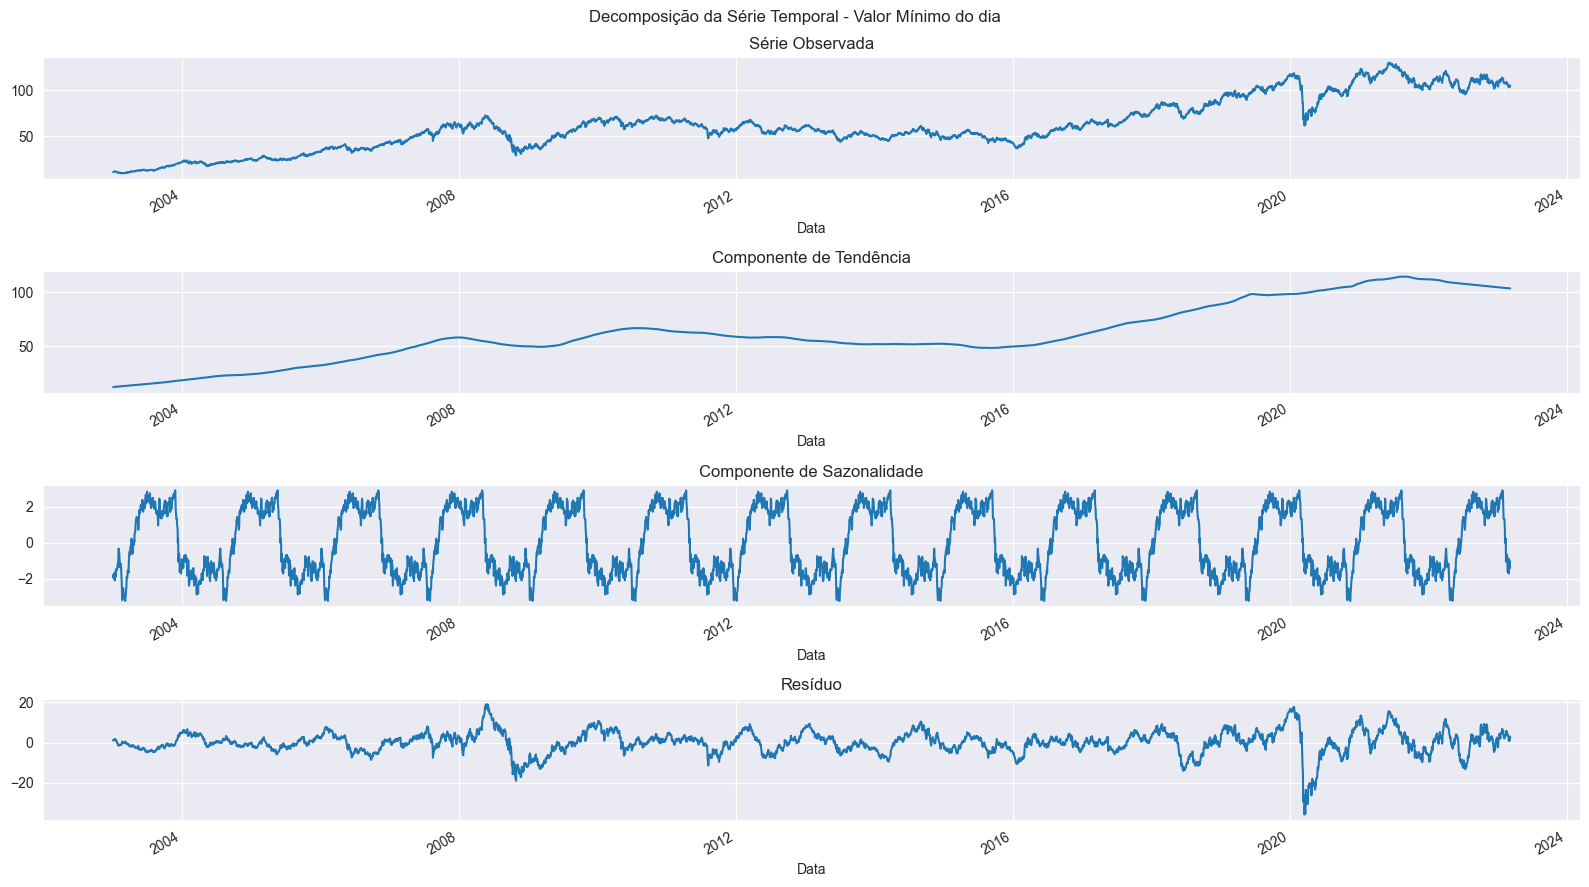

In [17]:
resultados = seasonal_decompose(df['Mínima'], model='additive', period=365, two_sided=True, extrapolate_trend=5)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 9))
resultados.observed.plot(ax=ax1)
ax1.set_xlabel('Data')
ax1.set_title('Série Observada')
resultados.trend.plot(ax=ax2)
ax2.set_xlabel('Data')
ax2.set_title('Componente de Tendência')
resultados.seasonal.plot(ax=ax3)
ax3.set_xlabel('Data')
ax3.set_title('Componente de Sazonalidade')
resultados.resid.plot(ax=ax4)
ax4.set_xlabel('Data')
ax4.set_title('Resíduo')
plt.suptitle('Decomposição da Série Temporal - Valor Mínimo do dia', fontsize=12)
plt.tight_layout()
plt.show()

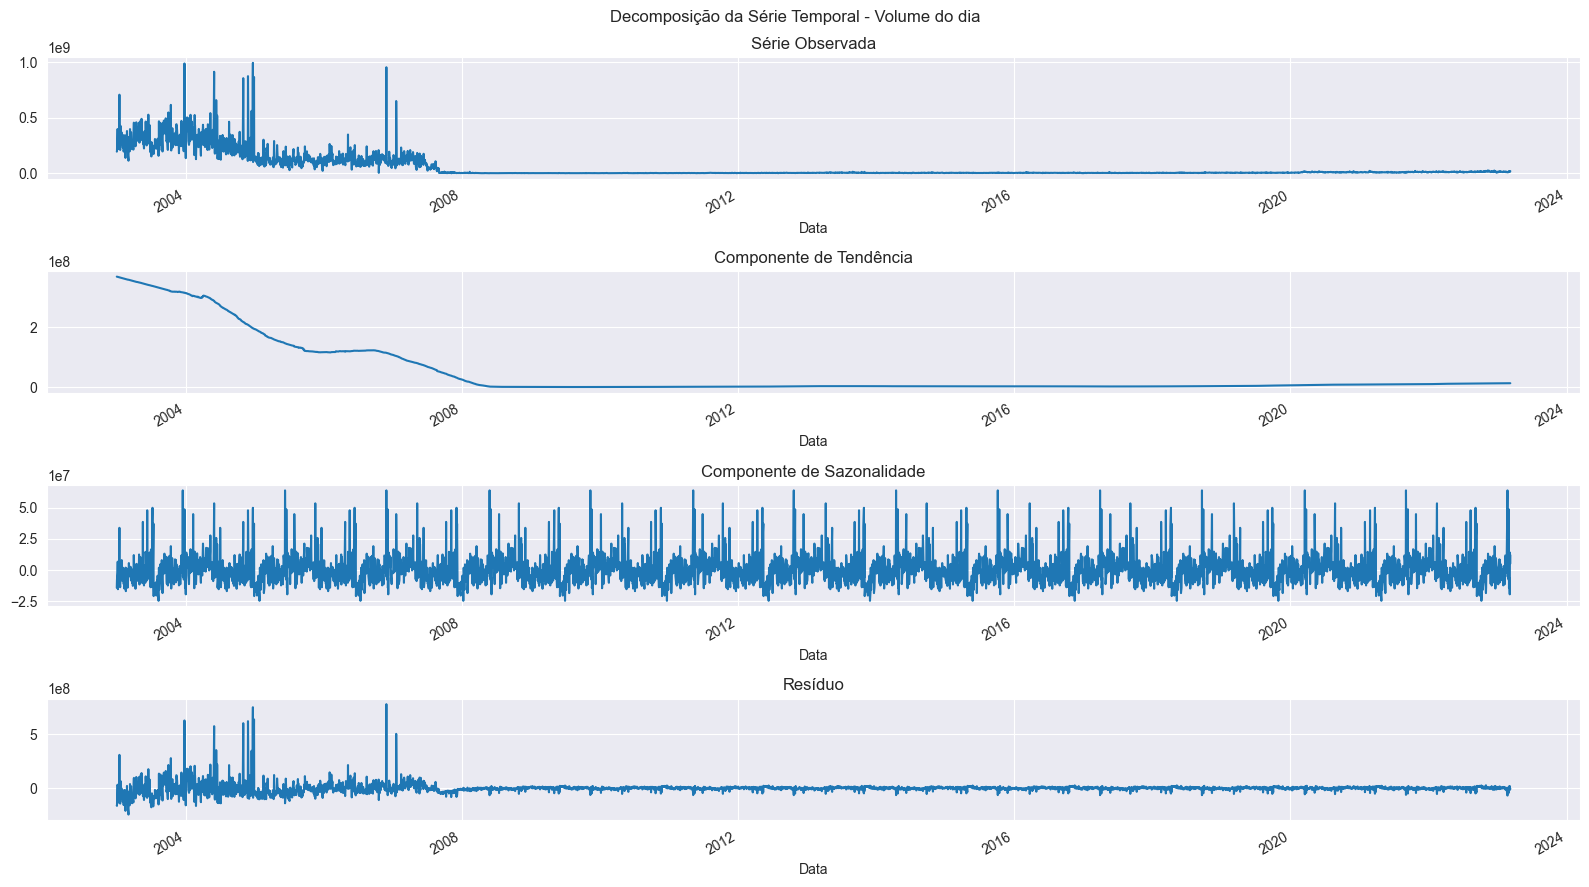

In [18]:
resultados = seasonal_decompose(df['Vol.'], model='additive', period=365, two_sided=True, extrapolate_trend=5)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 9))
resultados.observed.plot(ax=ax1)
ax1.set_xlabel('Data')
ax1.set_title('Série Observada')
resultados.trend.plot(ax=ax2)
ax2.set_xlabel('Data')
ax2.set_title('Componente de Tendência')
resultados.seasonal.plot(ax=ax3)
ax3.set_xlabel('Data')
ax3.set_title('Componente de Sazonalidade')
resultados.resid.plot(ax=ax4)
ax4.set_xlabel('Data')
ax4.set_title('Resíduo')
plt.suptitle('Decomposição da Série Temporal - Volume do dia', fontsize=12)
plt.tight_layout()
plt.show()

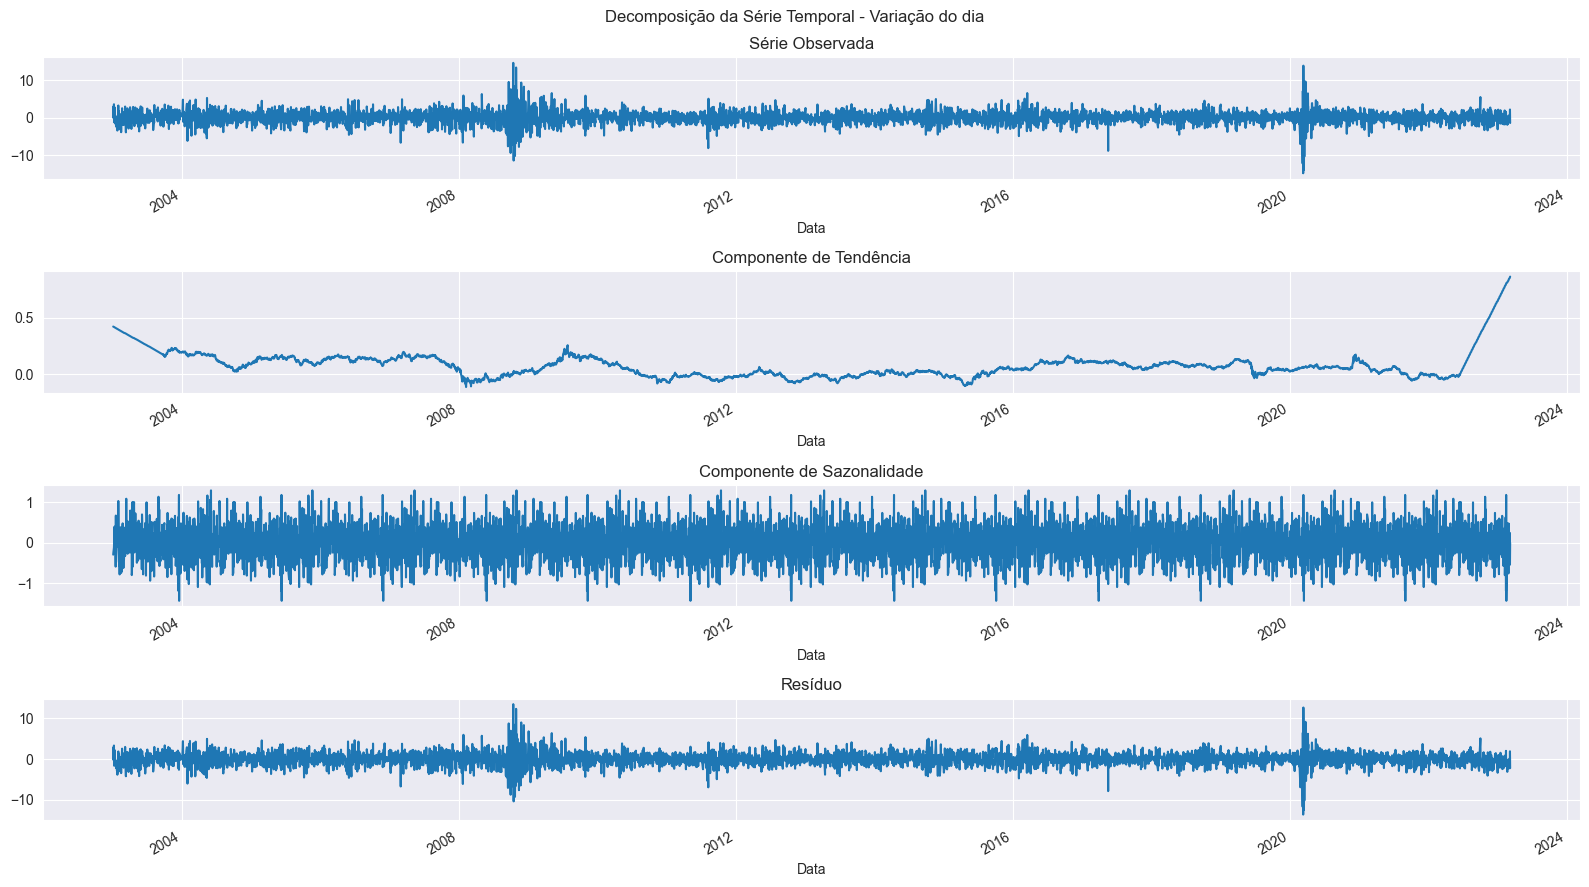

In [19]:
resultados = seasonal_decompose(df['Var%'], model='additive', period=365, two_sided=True, extrapolate_trend=5)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 9))
resultados.observed.plot(ax=ax1)
ax1.set_xlabel('Data')
ax1.set_title('Série Observada')
resultados.trend.plot(ax=ax2)
ax2.set_xlabel('Data')
ax2.set_title('Componente de Tendência')
resultados.seasonal.plot(ax=ax3)
ax3.set_xlabel('Data')
ax3.set_title('Componente de Sazonalidade')
resultados.resid.plot(ax=ax4)
ax4.set_xlabel('Data')
ax4.set_title('Resíduo')
plt.suptitle('Decomposição da Série Temporal - Variação do dia', fontsize=12)
plt.tight_layout()
plt.show()

#### Teste Augmented Dickey Fuller

> Hipótese
---
- H0 - Hipótese Nula (não é estacionária) não é estacionaria
- H1 - Hipótese Alternativa (rejeição da hipótese nula) é estacionaria

In [20]:
result = adfuller(df['Último'].values)
print('Teste ADf')
print(f'Teste estatistico: {result[0]}')
print(f'P-Value: {result[1]}')
print(f'Valores criticos:')

for key, value in result[4].items(): #type: ignore
    print(f'\t{key}: {value}')

Teste ADf
Teste estatistico: -1.582468902453259
P-Value: 0.4923936999320565
Valores criticos:
	1%: -3.431661944885779
	5%: -2.8621197374408225
	10%: -2.5670785949998973


> Resultado
---
- p-value 49% e teste estatístico maior que os valores criticos: Não é estacionaria

In [21]:
result = adfuller(df['Abertura'].values)
print('Teste ADf')
print(f'Teste estatistico: {result[0]}')
print(f'P-Value: {result[1]}')
print(f'Valores criticos:')

for key, value in result[4].items(): #type: ignore
    print(f'\t{key}: {value}')

Teste ADf
Teste estatistico: -1.5501918275983444
P-Value: 0.5085523743201463
Valores criticos:
	1%: -3.431661944885779
	5%: -2.8621197374408225
	10%: -2.5670785949998973


> Resultado
---
- p-value 50% e teste estatístico maior que os valores criticos: Não é estacionaria

In [22]:
result = adfuller(df['Máxima'].values)
print('Teste ADf')
print(f'Teste estatistico: {result[0]}')
print(f'P-Value: {result[1]}')
print(f'Valores criticos:')

for key, value in result[4].items(): #type: ignore
    print(f'\t{key}: {value}')

Teste ADf
Teste estatistico: -1.4916190799798554
P-Value: 0.5376531111835645
Valores criticos:
	1%: -3.4316614186797896
	5%: -2.8621195049660733
	10%: -2.567078471244475


> Resultado
---
- p-value 53% e teste estatístico maior que os valores criticos: Não é estacionaria

In [23]:
result = adfuller(df['Mínima'].values)
print('Teste ADf')
print(f'Teste estatistico: {result[0]}')
print(f'P-Value: {result[1]}')
print(f'Valores criticos:')

for key, value in result[4].items(): #type: ignore
    print(f'\t{key}: {value}')

Teste ADf
Teste estatistico: -1.548002712983739
P-Value: 0.5096457127083619
Valores criticos:
	1%: -3.4316614186797896
	5%: -2.8621195049660733
	10%: -2.567078471244475


> Resultado
---
- p-value 50% e teste estatístico maior que os valores criticos: Não é estacionaria

In [24]:
result = adfuller(df['Vol.'].values)
print('Teste ADf')
print(f'Teste estatistico: {result[0]}')
print(f'P-Value: {result[1]}')
print(f'Valores criticos:')

for key, value in result[4].items(): #type: ignore
    print(f'\t{key}: {value}')

Teste ADf
Teste estatistico: -2.7568043244385723
P-Value: 0.06471377739716942
Valores criticos:
	1%: -3.4316669649844727
	5%: -2.8621219552891963
	10%: -2.5670797756478825


> Resultado
---
- p-value 6% e teste estatístico maior que os valor critico de 5%: Não é estacionaria

In [25]:
result = adfuller(df['Var%'].values)
print('Teste ADf')
print(f'Teste estatistico: {result[0]}')
print(f'P-Value: {result[1]}')
print(f'Valores criticos:')

for key, value in result[4].items(): #type: ignore
    print(f'\t{key}: {value}')

Teste ADf
Teste estatistico: -31.11745683270484
P-Value: 0.0
Valores criticos:
	1%: -3.431660367533127
	5%: -2.862119040575461
	10%: -2.5670782240311683


> Resultado
---
p-value 0.0% e teste estatístico menor que os valores criticos: É estacionaria

Converter séries Último fechamento em estacionarias

- remover tendencia e sazonalidade, fazer a aproximação(transformada logaritmo e subtrair da média móvel)
- média móvel aplicada a linha da tendencia
- uma janela móvel de tamanho 12 meses é aplicada sobre os dados
- aplicar log
- subtrair a média móvel
- derivadas de um número de polinômio de primeiro grau deixando mais estacionaria.

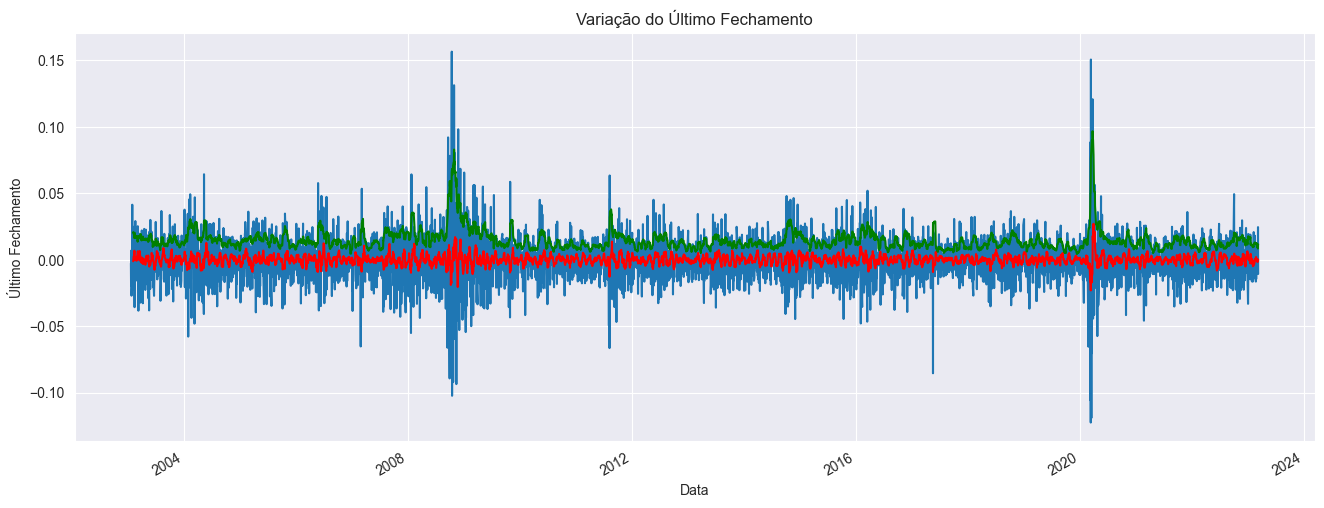

In [26]:
df_log = np.log(df[['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'y']])
df_log_meam = df_log.rolling(12).mean() # type: ignore
df_log = (df_log - df_log_meam).dropna()
df_diff = df_log.diff(1).dropna()# primeira derivara
df_ultimo_diff = df_diff['y']
df_ultimo_mean = df_ultimo_diff.rolling(12).mean()
df_ultimo_std = df_ultimo_diff.rolling(12).std()

plt.subplots(figsize=(16, 6))
df_ultimo_diff.plot(legend=False)
df_ultimo_mean.plot(legend=False, color='r')
df_ultimo_std.plot(legend=False, color='g')
plt.xlabel('Data')
plt.ylabel('Último Fechamento')
plt.title('Variação do Último Fechamento')
plt.show()

In [27]:
result = adfuller(df_ultimo_diff.dropna().values)
print('Teste ADf')
print(f'Teste estatistico: {result[0]}')
print(f'P-Value: {result[1]}')
print(f'Valores criticos:')

for key, value in result[4].items(): #type: ignore
    print(f'\t{key}: {value}')

Teste ADf
Teste estatistico: -18.933046195630858
P-Value: 0.0
Valores criticos:
	1%: -3.431670688657576
	5%: -2.862123600382394
	10%: -2.567080651396155


> Resultado
---
p-value 0.0% e teste estatístico menor que os valores criticos: É estacionaria

##### autocorrelação (ACF) e função de autocorrelação parcial (PACF)
---
- 5% ACF -> (intervalo de confiança).
- 1.96/sqrt(N-d) -> **N** número de pontos e **d** é o número de vezes que os dados foram diferenciamos (intervalo de confiança para estimativas de autocorrelação significativa).

In [28]:
def autocorrelation_function(df, lag):
    return acf(df.dropna(), nlags=lag)

def partial_autocorrelation_function(df, lag):
    return pacf(df.dropna(), nlags=lag)

def mape_error(y_true, y_pred):
    n = len(y_true)
    mape = (np.abs((y_true - y_pred) / y_true).sum() / n)
    print(f"MAPE (Mean Absolute Percentage Error): {mape:.2%}")
    return mape

def wmape_error(y_true, y_pred):
    wmape = np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()
    print(f"WMAPE (Weighted Mean Absolute Percentage Error): {wmape:.2%}")
    return wmape

def smape_error(y_true, y_pred):
    smape = (np.abs(y_pred - y_true) * 2 / (np.abs(y_pred) + np.abs(y_true))).mean()
    print(f"SMAPE (Symmetric Mean Absolute Percentage Error): {smape:.2%}")
    return smape

$$MAPE = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_{\text{true},i} - y_{\text{pred},i}}{y_{\text{true},i}} \right| \times 100$$
---
$$WMAPE = \frac{\sum_{i=1}^{n} \left| y_{\text{true},i} - y_{\text{pred},i} \right|}{\sum_{i=1}^{n} \left| y_{\text{true},i} \right|} \times 100$$
---
$$SMAPE = \frac{100}{n} \sum_{i=1}^{n} \frac{\left| y_{\text{pred},i} - y_{\text{true},i} \right|}{(|y_{\text{pred},i}| + |y_{\text{true},i}|)/2}$$

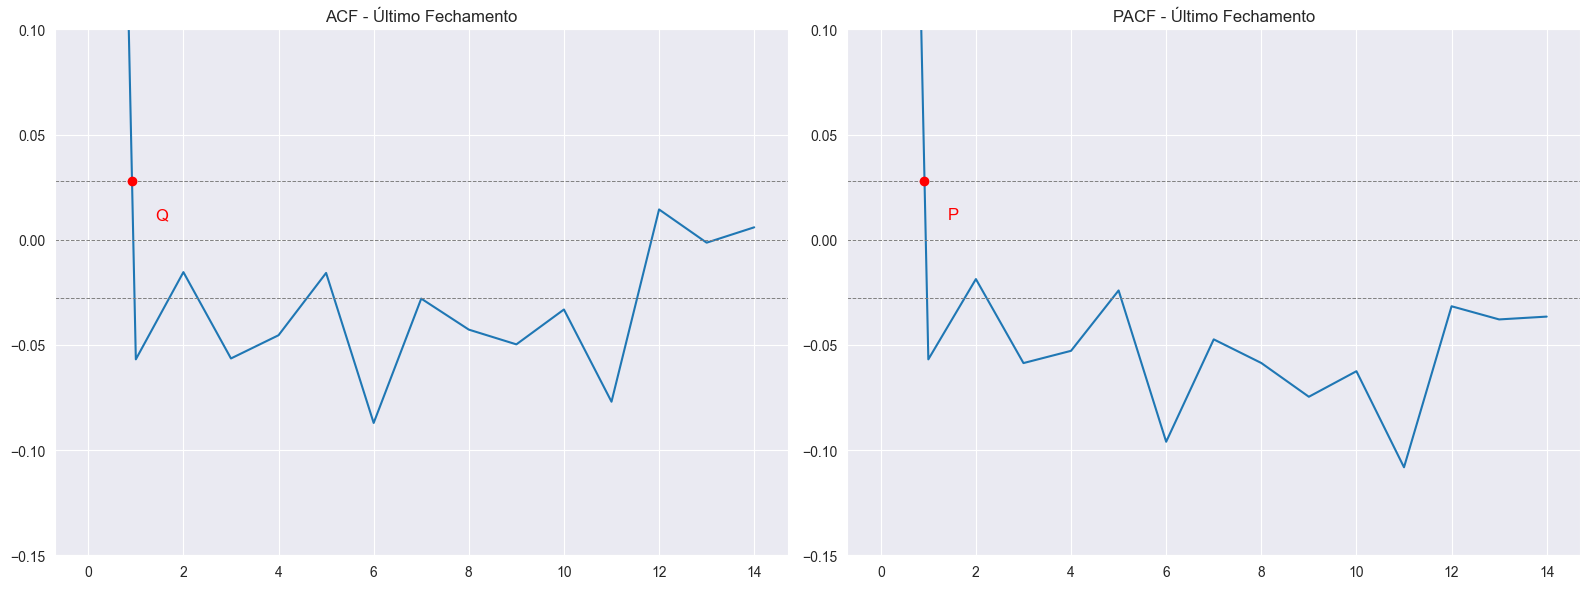

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(autocorrelation_function(df_ultimo_diff, 14))
ax[0].axhline(y=-1.96/(np.sqrt((len(df_ultimo_diff) -1))), linestyle='--', color='gray', linewidth=0.7)
ax[0].axhline(y=0, linestyle='--', color='gray', linewidth=0.7)
ax[0].axhline(y=1.96/(np.sqrt((len(df_ultimo_diff) -1))), linestyle='--', color='gray', linewidth=0.7)
ax[0].set_title('ACF - Último Fechamento')
ax[0].set_ylim(-0.15, 0.1)
ax[1].plot(partial_autocorrelation_function(df_ultimo_diff, 14))
ax[1].axhline(y=-1.96/(np.sqrt((len(df_ultimo_diff) -1))), linestyle='--', color='gray', linewidth=0.7)
ax[1].axhline(y=0, linestyle='--', color='gray', linewidth=0.7)
ax[1].axhline(y=1.96/(np.sqrt((len(df_ultimo_diff) -1))), linestyle='--', color='gray', linewidth=0.7)
ax[1].set_title('PACF - Último Fechamento')
ax[1].set_ylim(-0.15, 0.1)

q_value = 0.915
p_value = 0.915
ax[0].plot(q_value, 0.028, 'ro')
ax[1].plot(p_value, 0.028, 'ro')
ax[0].annotate('Q', xy=(p_value + 0.5, 0.01), fontsize=12, color='red')
ax[1].annotate('P', xy=(q_value + 0.5, 0.01), fontsize=12, color='red')

plt.tight_layout()
plt.show()

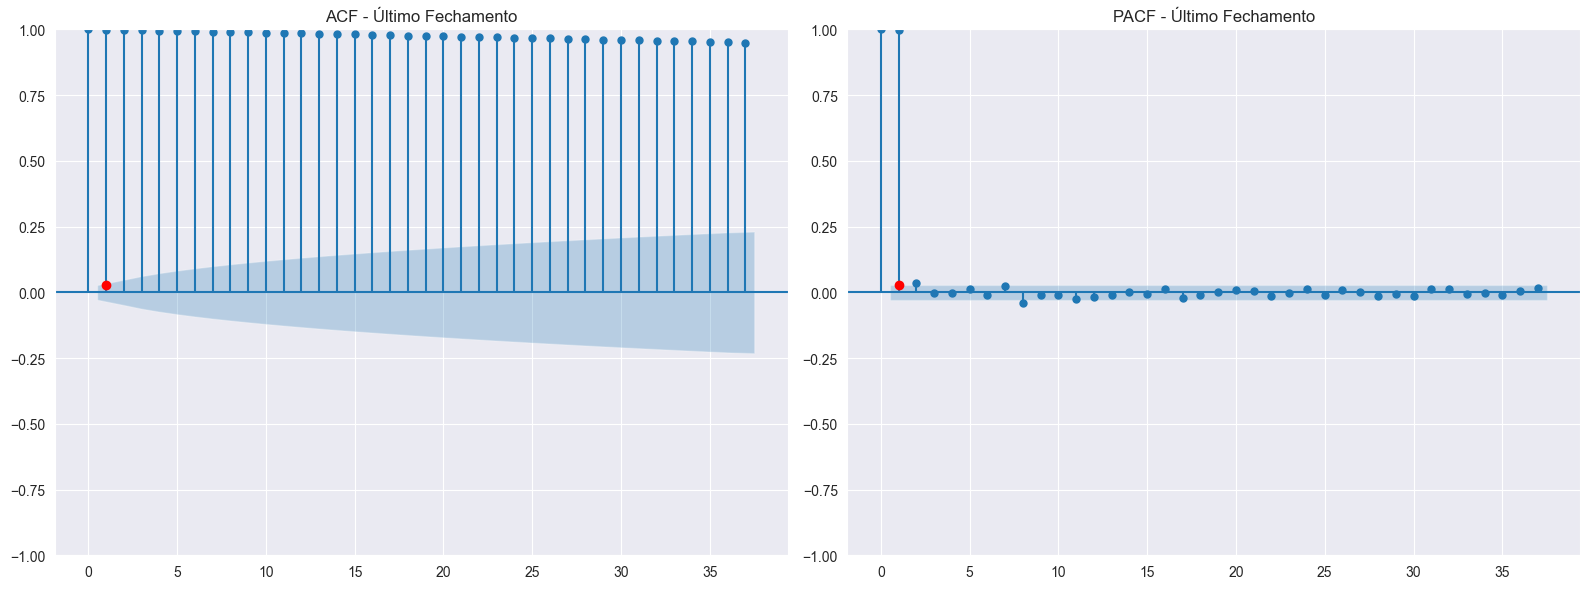

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df['Último'], ax=ax[0])
ax[0].set_title('ACF - Último Fechamento')
ax[0].plot(1, 1.96/np.sqrt(len(df['Último']) - 1), 'ro')
plot_pacf(df['Último'], ax=ax[1])
ax[1].set_title('PACF - Último Fechamento')
ax[1].plot(1, 1.96/np.sqrt(len(df['Último']) - 1), 'ro')
plt.tight_layout()
plt.show()

#####  ARIMA (P, D, Q)
---
- Ordem de diferenciação **D** = 1 (Foi necessária 1 diferenciação para tornar a série estacionaria)
- **Q acf** = 0.915
- **P pacf** = 0.915

In [31]:
# train = df_diff.loc[df.ds < '2022-12-01'].copy()
# test = df_diff.loc[df.ds >= '2022-12-01'].copy()
train = df.loc[df.ds < '2022-12-30'].copy()
test = df.loc[df.ds >= '2022-12-30'].copy()
train.loc[:, 'unique_id'] = 'Fechamento'
train['ds'] = train.index
test.loc[:, 'unique_id'] = 'Fechamento'
test['ds'] = test.index
train.drop(['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], inplace=True, axis=1)
test.drop(['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], inplace=True, axis=1)
h = test.index.nunique()
print(train.shape)
print(test.shape)
print(h)
# Data mais antiga: 2003-01-02 00:00:00
# Data mais recente: 2023-03-09 00:00:00

(4952, 3)
(47, 3)
47


WMAPE (Weighted Mean Absolute Percentage Error): 2.06%
SMAPE (Symmetric Mean Absolute Percentage Error): 2.06%
MAPE (Mean Absolute Percentage Error): 2.05%


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


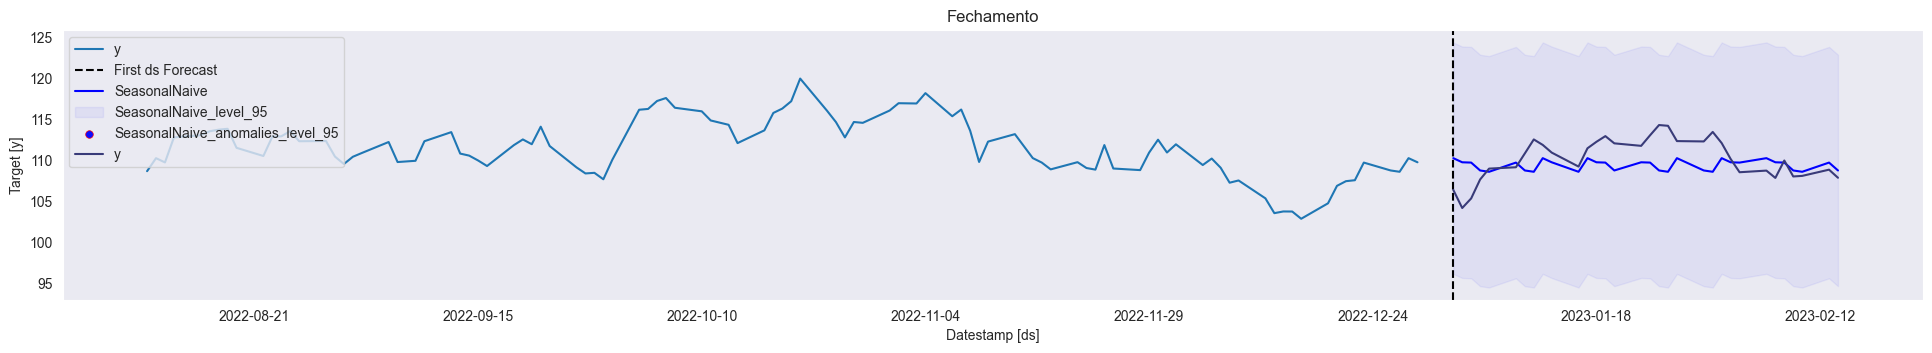

In [32]:
model = StatsForecast(models=[SeasonalNaive(season_length=5)], freq='D', n_jobs=-1)
model.fit(train)
forecast = model.predict(h=h, level=[95])
forecast = forecast.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast.dropna(inplace=True)

wmape = wmape_error(forecast['y'].values, forecast['SeasonalNaive'].values)
smape = smape_error(forecast['y'].values, forecast['SeasonalNaive'].values)
mape = mape_error(forecast['y'].values, forecast['SeasonalNaive'].values)

model.plot(
    train,
    forecast,
    level=[95],
    engine='matplotlib',
    max_insample_length=99,
    plot_anomalies=True
)

WMAPE (Weighted Mean Absolute Percentage Error): 2.90%
SMAPE (Symmetric Mean Absolute Percentage Error): 2.92%
MAPE (Mean Absolute Percentage Error): 2.87%


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


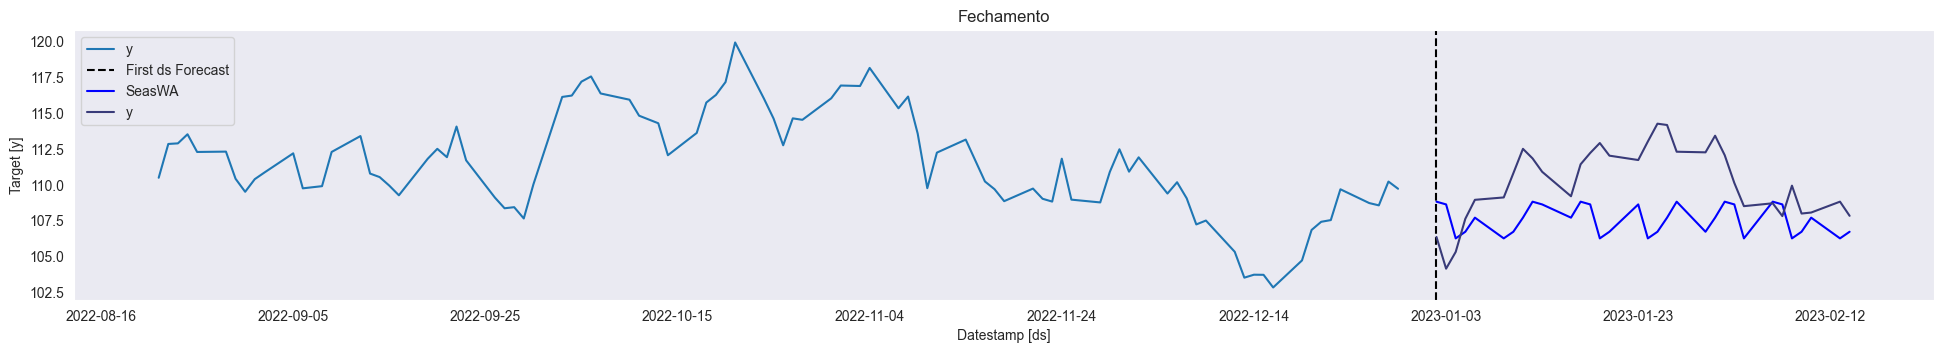

In [33]:
model = StatsForecast(models=[SeasonalWindowAverage(season_length=5, window_size=2)], freq='D', n_jobs=-1) #season_length 5 = seg a sex window_size 2 = 2 semanas/mes
model.fit(train)
forecast = model.predict(h=h, level=[95])
forecast = forecast.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast.dropna(inplace=True)

wmape = wmape_error(forecast['y'].values, forecast['SeasWA'].values)
smape = smape_error(forecast['y'].values, forecast['SeasWA'].values)
mape = mape_error(forecast['y'].values, forecast['SeasWA'].values)

model.plot(
    train,
    forecast,
    level=[95],
    engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

WMAPE (Weighted Mean Absolute Percentage Error): 2.16%
SMAPE (Symmetric Mean Absolute Percentage Error): 2.16%
MAPE (Mean Absolute Percentage Error): 2.15%


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


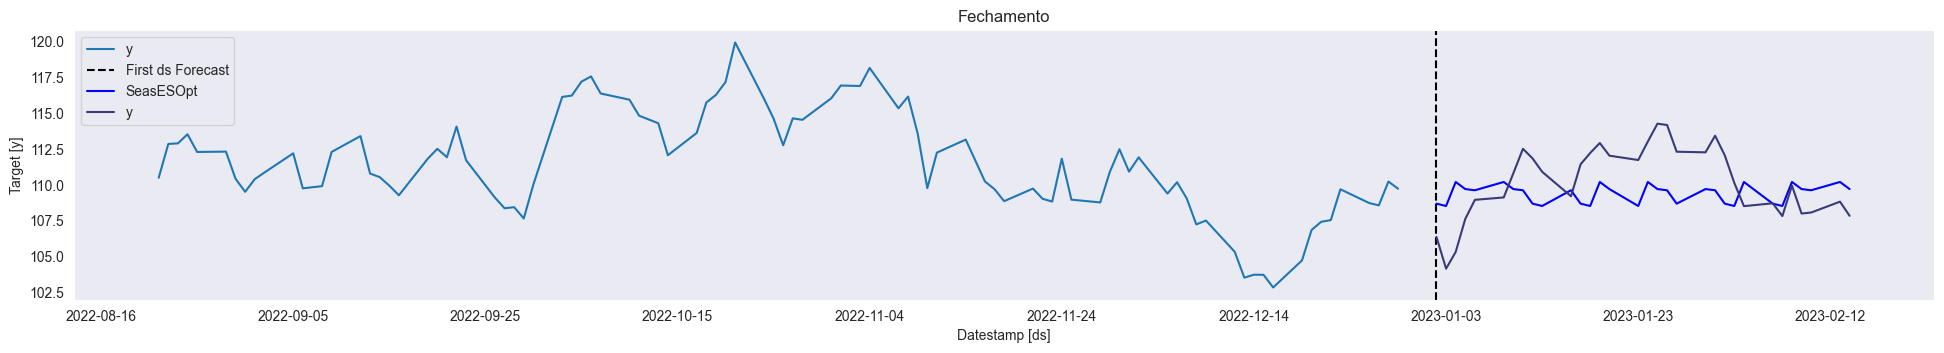

In [34]:
model = StatsForecast(models=[SeasonalExponentialSmoothingOptimized(season_length=5)], freq='D', n_jobs=-1)
model.fit(train)
forecast = model.predict(h=h, level=[95])
forecast = forecast.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast.dropna(inplace=True)

wmape = wmape_error(forecast['y'].values, forecast['SeasESOpt'].values)
smape = smape_error(forecast['y'].values, forecast['SeasESOpt'].values)
mape = mape_error(forecast['y'].values, forecast['SeasESOpt'].values)

model.plot(
    train,
    forecast,
    level=[95],
    engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


WMAPE (Weighted Mean Absolute Percentage Error): 1.98%
SMAPE (Symmetric Mean Absolute Percentage Error): 1.99%
MAPE (Mean Absolute Percentage Error): 1.98%


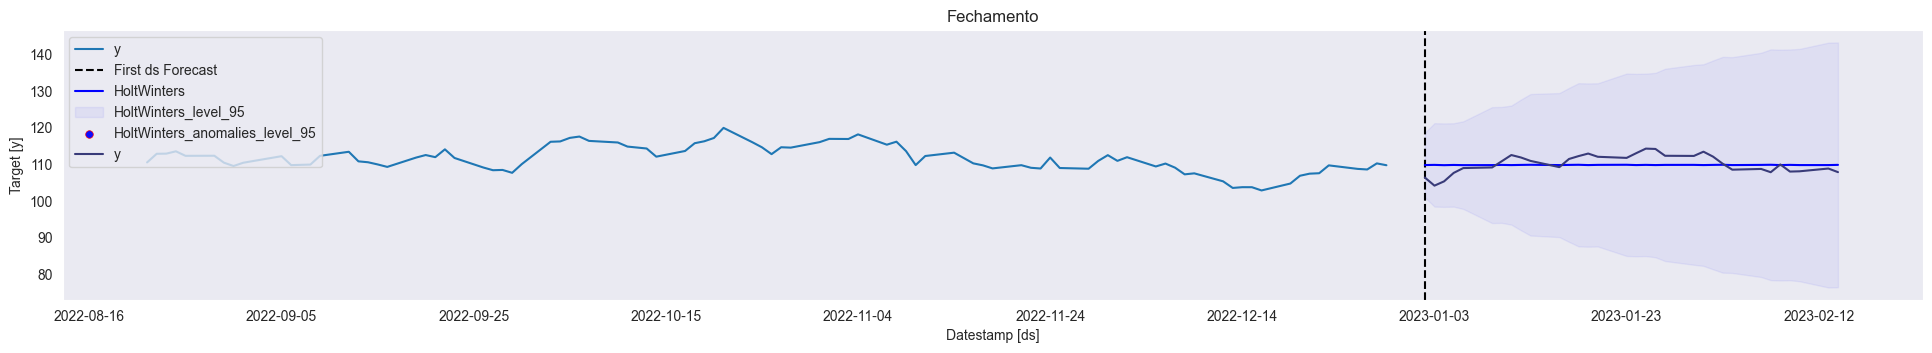

In [35]:
model = StatsForecast(models=[HoltWinters(season_length=5, error_type='M')], freq='D', n_jobs=-1)
model.fit(train)
forecast = model.predict(h=h, level=[95])
forecast = forecast.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast.dropna(inplace=True)

wmape = wmape_error(forecast['y'].values, forecast['HoltWinters'].values)
smape = smape_error(forecast['y'].values, forecast['HoltWinters'].values)
mape = mape_error(forecast['y'].values, forecast['HoltWinters'].values)

model.plot(
    train,
    forecast,
    level=[95],
    engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


WMAPE (Weighted Mean Absolute Percentage Error): 2.18%
SMAPE (Symmetric Mean Absolute Percentage Error): 2.18%
MAPE (Mean Absolute Percentage Error): 2.16%


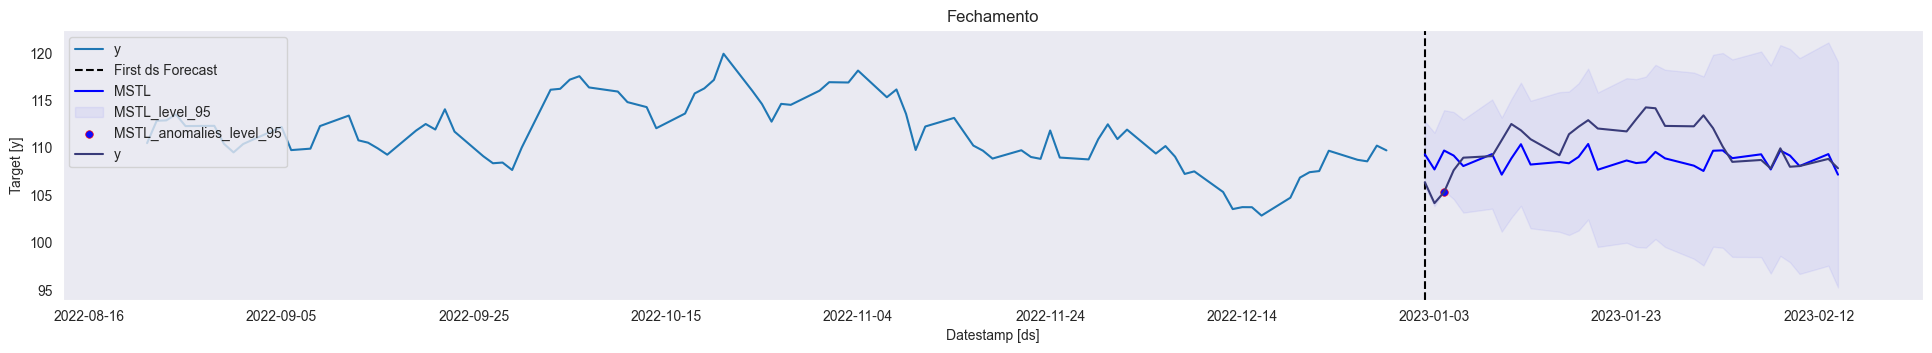

In [36]:
model = StatsForecast(models=[MSTL(season_length=[5, 7], trend_forecaster=AutoARIMA(start_P=1, start_Q=1))], freq='D', n_jobs=-1) #type: ignore
model.fit(train)
forecast = model.predict(h=h, level=[95])
forecast = forecast.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast.dropna(inplace=True)

wmape = wmape_error(forecast['y'].values, forecast['MSTL'].values)
smape = smape_error(forecast['y'].values, forecast['MSTL'].values)
mape = mape_error(forecast['y'].values, forecast['MSTL'].values)

model.plot(
    train,
    forecast,
    level=[95],
    engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


WMAPE (Weighted Mean Absolute Percentage Error): 2.00%
SMAPE (Symmetric Mean Absolute Percentage Error): 2.00%
MAPE (Mean Absolute Percentage Error): 1.99%


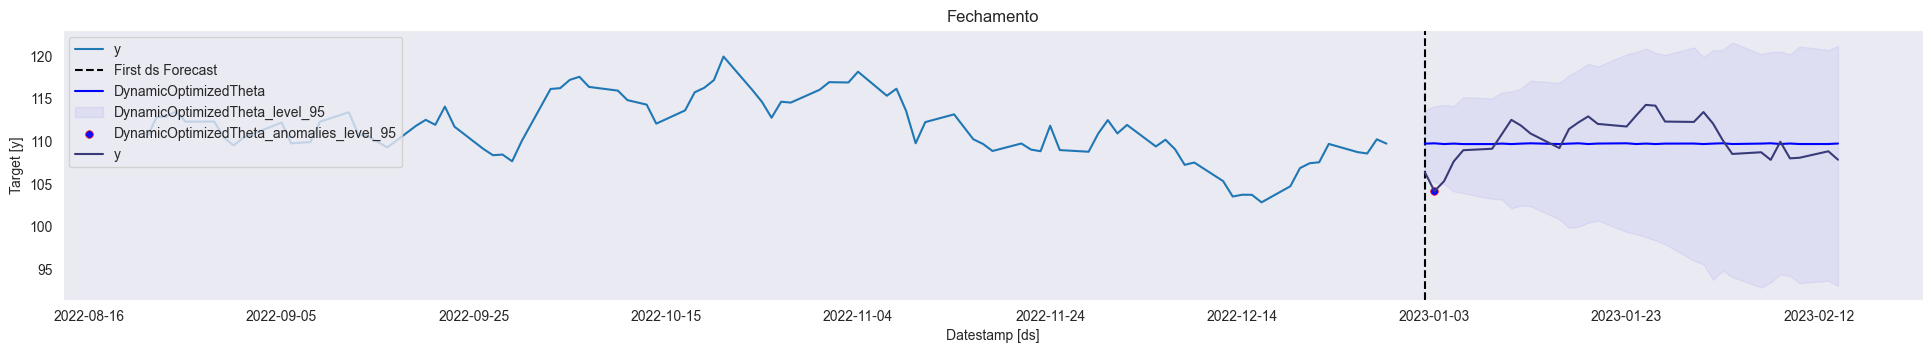

In [37]:
model = StatsForecast(models=[DynamicOptimizedTheta(season_length=5)], freq='D', n_jobs=-1)
model.fit(train)
forecast = model.predict(h=h, level=[95])
forecast = forecast.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast.dropna(inplace=True)

wmape = wmape_error(forecast['y'].values, forecast['DynamicOptimizedTheta'].values)
smape = smape_error(forecast['y'].values, forecast['DynamicOptimizedTheta'].values)
mape = mape_error(forecast['y'].values, forecast['DynamicOptimizedTheta'].values)

model.plot(
    train,
    forecast,
    level=[95],
    engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


WMAPE (Weighted Mean Absolute Percentage Error): 1.97%
SMAPE (Symmetric Mean Absolute Percentage Error): 1.97%
MAPE (Mean Absolute Percentage Error): 1.97%


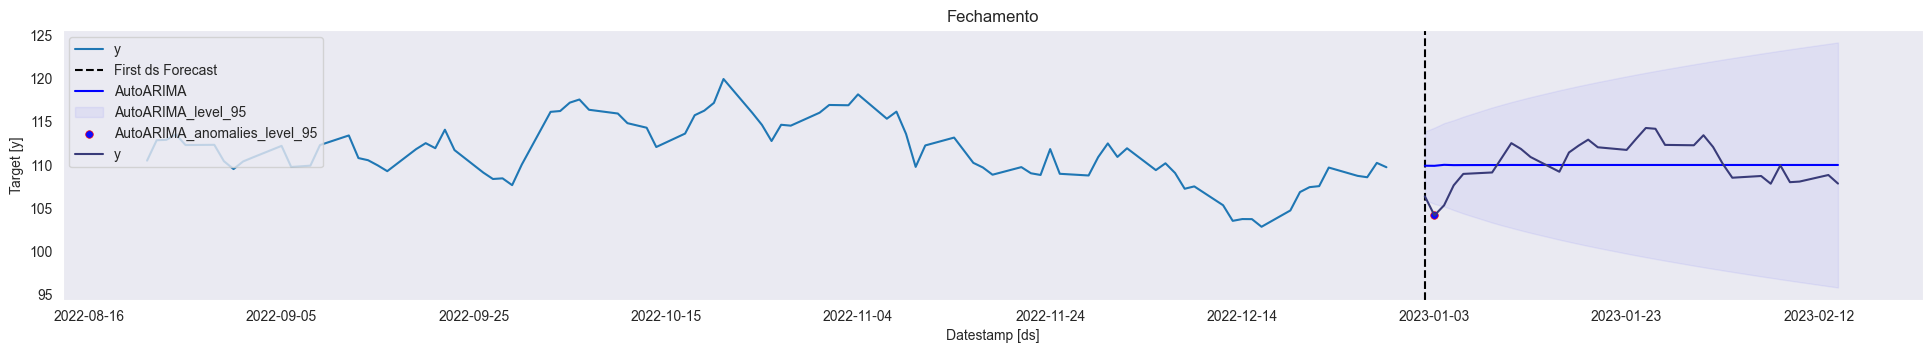

In [38]:
model = StatsForecast(models=[AutoARIMA(season_length=7, start_P=1, start_Q=1)], freq='D', n_jobs=-1)
model.fit(train)
forecast = model.predict(h=h, level=[95])
forecast = forecast.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast.dropna(inplace=True)

wmape = wmape_error(forecast['y'].values, forecast['AutoARIMA'].values)
smape = smape_error(forecast['y'].values, forecast['AutoARIMA'].values)
mape = mape_error(forecast['y'].values, forecast['AutoARIMA'].values)

model.plot(
    train,
    forecast,
    level=[95],
    engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

/Users/marcelocardoso/Documents/.venv/lib/python3.10/site-packages/statsforecast/ces.py:528: RuntimeWarning: overflow encountered in square
  sigma2 = np.sum(e**2) / (ny - np_ - 1)
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


WMAPE (Weighted Mean Absolute Percentage Error): 1.99%
SMAPE (Symmetric Mean Absolute Percentage Error): 1.99%
MAPE (Mean Absolute Percentage Error): 1.99%


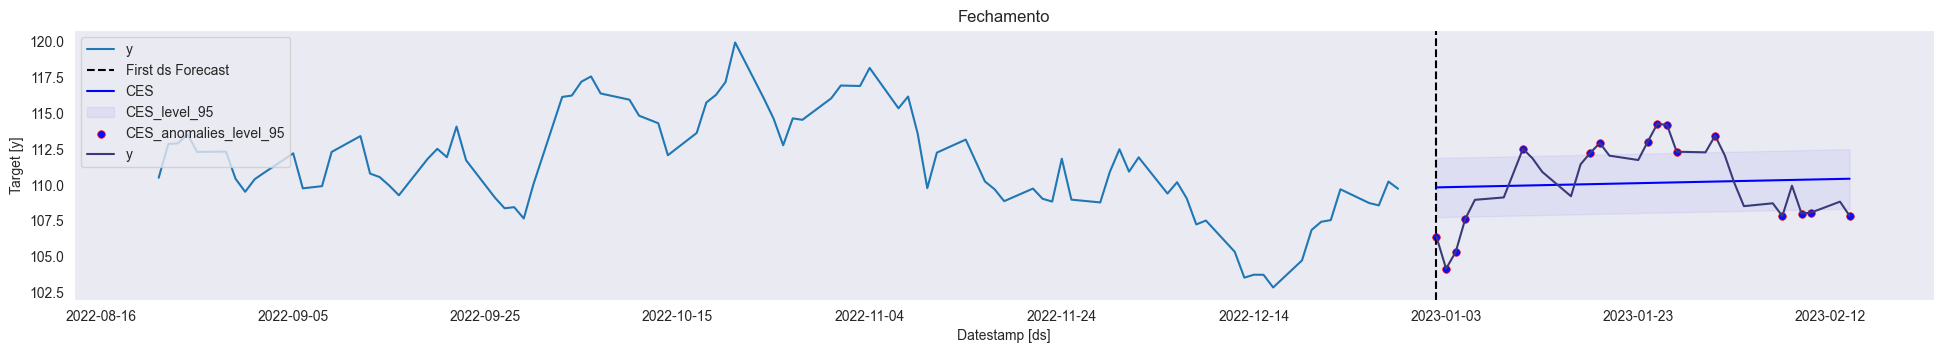

In [39]:
model = StatsForecast(models=[AutoCES(model='Z', season_length=5)], freq='D', n_jobs=-1)
model.fit(train)
forecast = model.predict(h=h, level=[95])
forecast = forecast.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast.dropna(inplace=True)

wmape = wmape_error(forecast['y'].values, forecast['CES'].values)
smape = smape_error(forecast['y'].values, forecast['CES'].values)
mape = mape_error(forecast['y'].values, forecast['CES'].values)

model.plot(
    train,
    forecast,
    level=[95],
    engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

WMAPE (Weighted Mean Absolute Percentage Error): 1.99%
SMAPE (Symmetric Mean Absolute Percentage Error): 1.99%
MAPE (Mean Absolute Percentage Error): 1.99%


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


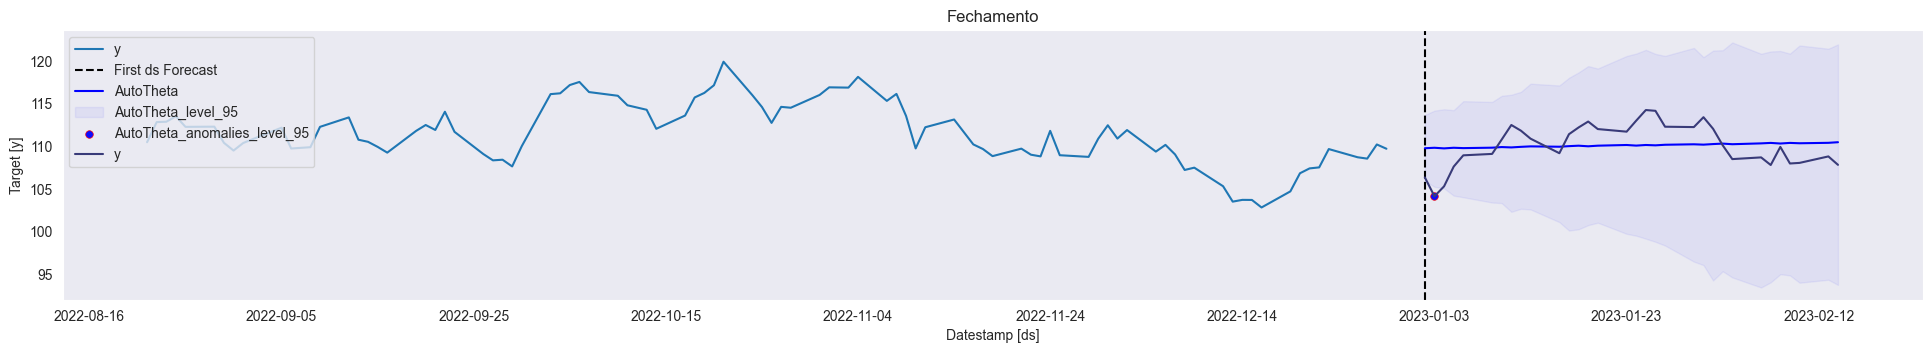

In [40]:
model = StatsForecast(models=[AutoTheta(season_length=5)], freq='D', n_jobs=-1)
model.fit(train)
forecast = model.predict(h=h, level=[95])
forecast = forecast.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast.dropna(inplace=True)

wmape = wmape_error(forecast['y'].values, forecast['AutoTheta'].values)
smape = smape_error(forecast['y'].values, forecast['AutoTheta'].values)
mape = mape_error(forecast['y'].values, forecast['AutoTheta'].values)

model.plot(
    train,
    forecast,
    level=[95],
    engine='matplotlib',
    max_insample_length=90,
    plot_anomalies=True
)

In [41]:
model = StatsForecast(
    models=[
        Naive(),
        SeasonalNaive(season_length=5),
        SeasonalWindowAverage(season_length=5, window_size=2),
        WindowAverage(window_size=2),
        RandomWalkWithDrift(),
        HistoricAverage(),
        SimpleExponentialSmoothing(alpha=0.001),
        SimpleExponentialSmoothingOptimized(),
        SeasonalExponentialSmoothing(alpha=0.001, season_length=5),
        SeasonalExponentialSmoothingOptimized(season_length=5),
        Holt(season_length=5, error_type='M'),
        HoltWinters(season_length=5, error_type='M'),
        ADIDA(),
        CrostonClassic(),
        CrostonOptimized(),
        CrostonSBA(),
        IMAPA(),
        TSB(alpha_d=0.005, alpha_p=0.005),
        MSTL(season_length=[5, 7], trend_forecaster=AutoARIMA(start_P=1, start_Q=1)), # type: ignore
        DynamicOptimizedTheta(season_length=5),
        GARCH(p=10, q=1),
        AutoARIMA(season_length=5),
        AutoETS(model='ZZZ', season_length=5),
        AutoCES(model='Z', season_length=5),
        AutoTheta(season_length=5),
        ARCH(p=10)
    ],
    freq='D',
    n_jobs=-1
)
model.fit(train)
forecast = model.predict(h=h, level=[95])
forecast = forecast.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast.dropna(inplace=True)

/Users/marcelocardoso/Documents/.venv/lib/python3.10/site-packages/statsforecast/ces.py:528: RuntimeWarning: overflow encountered in square
  sigma2 = np.sum(e**2) / (ny - np_ - 1)
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


In [42]:
sarima_model = SARIMAX(train['y'], order=(1, 1, 1), seasonal_order=(0, 1, 0, 5))  # 5 de segunda a sexta
sarima = sarima_model.fit(disp=False)

sarima_forecast = sarima.get_forecast(steps=h) # type: ignore
sarima_forecast_result = sarima_forecast.predicted_mean
sarima_df = pd.DataFrame({'predicted_mean': sarima_forecast_result.values}, index=test.index)

/Users/marcelocardoso/Documents/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/marcelocardoso/Documents/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/marcelocardoso/Documents/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/marcelocardoso/Documents/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling th

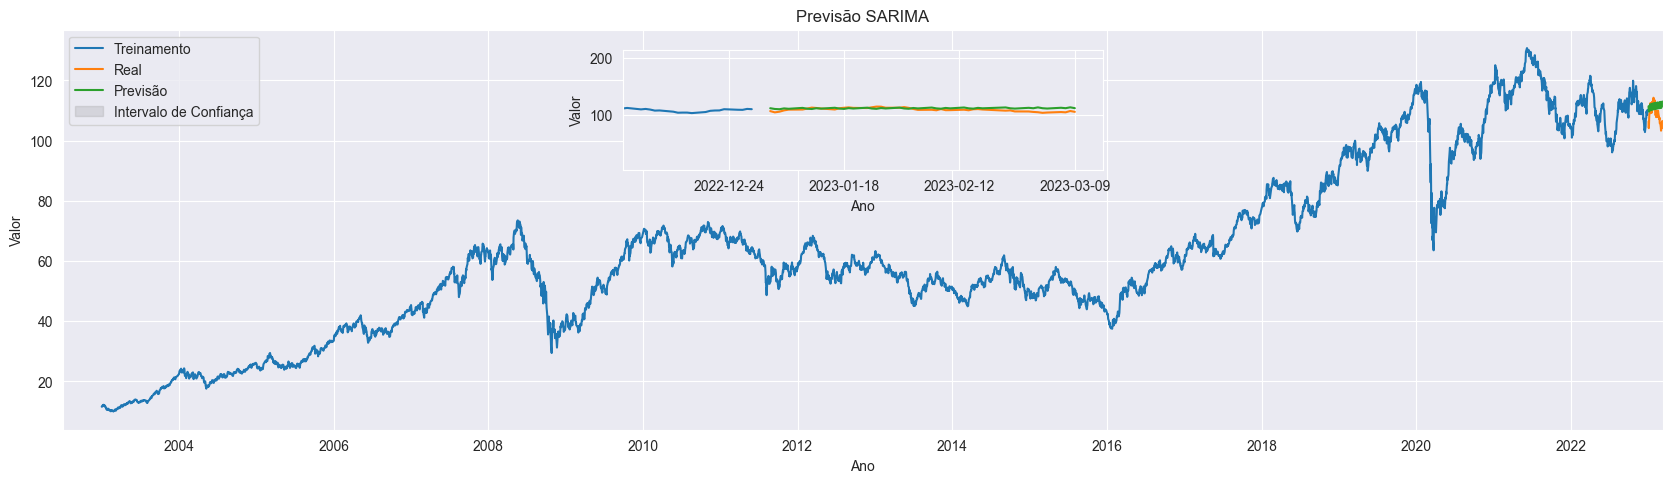

In [43]:
fig = plt.figure(figsize=(16, 4))
eixo = fig.add_axes([0, 0, 1, 1])
eixo.plot(train['y'], label='Treinamento')
eixo.plot(test.index, test['y'], label='Real')
eixo.plot(sarima_df.index, sarima_df['predicted_mean'], label='Previsão')
eixo.fill_between(
    sarima_forecast.conf_int().index,
    sarima_forecast.conf_int()['lower y'],
    sarima_forecast.conf_int()['upper y'],
    color='gray',
    alpha=0.2,
    label='Intervalo de Confiança'
)
eixo.legend()
eixo.set_title('Previsão SARIMA')
eixo.set_xlim(pd.Timestamp('2002-07-01'), test.index[-1]) # type: ignore
eixo.set_xlabel('Ano')
eixo.set_ylabel('Valor')
eixo2 = fig.add_axes([0.35, 0.65, 0.3, 0.3])
eixo2.plot(train['y'], label='Treinamento')
eixo2.plot(test.index, test['y'], label='Real')
eixo2.plot(sarima_df.index, sarima_df['predicted_mean'], label='Previsão')
eixo2.fill_between(
    sarima_forecast.conf_int().index,
    sarima_forecast.conf_int()['lower y'],
    sarima_forecast.conf_int()['upper y'],
    color='gray',
    alpha=0.2,
    label='Intervalo de Confiança'
)
eixo2.set_xlim(pd.Timestamp('2022-01-01'), pd.Timestamp('2023-12-31')) # type: ignore
eixo2.set_ylim(
    min(min(test['y']), min(sarima_df['predicted_mean'])) - 100, # type: ignore
    max(max(test['y']), max(sarima_df['predicted_mean'])) + 100 # type: ignore
)
eixo2.set_xlim(pd.Timestamp('2022-12-01'), pd.Timestamp('2023-03-15')) # type: ignore
eixo2.set_xlabel('Ano')
eixo2.set_ylabel('Valor')
eixo2.xaxis.set_major_locator(plt.MaxNLocator(5)) # type: ignore
plt.show()

In [44]:
train_data = train['y'].values.reshape(-1, 1) # type: ignore
test_data = test['y'].values.reshape(-1, 1) # type: ignore

scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data)
test_data_normalized = scaler.transform(test_data)

# Função para criar sequências para a LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:i+seq_length]
        target = data[i+seq_length-1]  # O último valor da sequência é usado como o alvo
        sequences.append((sequence, target))
    return sequences

seq_length = 5 
train_sequences = create_sequences(train_data_normalized, seq_length)

X_train = np.array([seq for seq, _ in train_sequences])
y_train = np.array([target for _, target in train_sequences])

# Criação do modelo LSTM
# model = Sequential([
#     LSTM(units=50, activation='relu', input_shape=(seq_length, 1)),
#     Dense(1)
# ])
# WMAPE (Weighted Mean Absolute Percentage Error): 3.63%
# SMAPE (Symmetric Mean Absolute Percentage Error): 3.60%
# MAPE (Mean Absolute Percentage Error): 3.70%

# model = Sequential([
#     LSTM(units=50, activation='sigmoid', input_shape=(seq_length, 1)),
#     Dense(1)
# ])
# WMAPE (Weighted Mean Absolute Percentage Error): 4.82%
# SMAPE (Symmetric Mean Absolute Percentage Error): 4.92%
# MAPE (Mean Absolute Percentage Error): 4.80%

# model = Sequential([
#     LSTM(units=50, activation='tanh', input_shape=(seq_length, 1)),
#     Dense(1)
# ])
# WMAPE (Weighted Mean Absolute Percentage Error): 3.11%
# SMAPE (Symmetric Mean Absolute Percentage Error): 3.10%
# MAPE (Mean Absolute Percentage Error): 3.16%

model_lstm = Sequential([
    LSTM(units=50, activation='linear', input_shape=(seq_length, 1)),
    Dense(1)
])

# from keras.layers import LeakyReLU
# model = Sequential([
#     LSTM(units=50, activation=LeakyReLU(alpha=0.01), input_shape=(seq_length, 1)),
#     Dense(1)
# ])
# WMAPE (Weighted Mean Absolute Percentage Error): 5.05%
# SMAPE (Symmetric Mean Absolute Percentage Error): 4.94%
# MAPE (Mean Absolute Percentage Error): 5.16%

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

model_lstm.fit(X_train, y_train, epochs=50, batch_size=16)

# Preparação dos dados de teste para entrada na LSTM
last_sequence = train_data_normalized[-seq_length:]
forecast_lstm = []

for _ in range(h):
    predicted_value = model_lstm.predict(last_sequence.reshape(1, seq_length, 1))
    forecast_lstm.append(predicted_value)
    last_sequence = np.concatenate((last_sequence[1:], predicted_value), axis=None)

forecast_lstm = np.array(forecast_lstm).reshape(-1, 1)
forecast_lstm = scaler.inverse_transform(forecast_lstm)
forecast_lstm_values = forecast_lstm.flatten()

Epoch 1/50
310/310 [==============================] - 1s 1ms/step - loss: 0.0092
Epoch 2/50
310/310 [==============================] - 0s 1ms/step - loss: 2.0967e-04
Epoch 3/50
310/310 [==============================] - 0s 1ms/step - loss: 1.2737e-04
Epoch 4/50
310/310 [==============================] - 1s 2ms/step - loss: 1.1905e-04
Epoch 5/50
310/310 [==============================] - 0s 1ms/step - loss: 1.1973e-04
Epoch 6/50
310/310 [==============================] - 0s 986us/step - loss: 1.1760e-04
Epoch 7/50
310/310 [==============================] - 0s 2ms/step - loss: 1.1423e-04
Epoch 8/50
310/310 [==============================] - 1s 2ms/step - loss: 1.1637e-04
Epoch 9/50
310/310 [==============================] - 1s 2ms/step - loss: 1.1230e-04
Epoch 10/50
310/310 [==============================] - 0s 1ms/step - loss: 1.0077e-04
Epoch 11/50
310/310 [==============================] - 0s 1ms/step - loss: 1.0534e-04
Epoch 12/50
310/310 [==============================] - 0s 1ms/ste

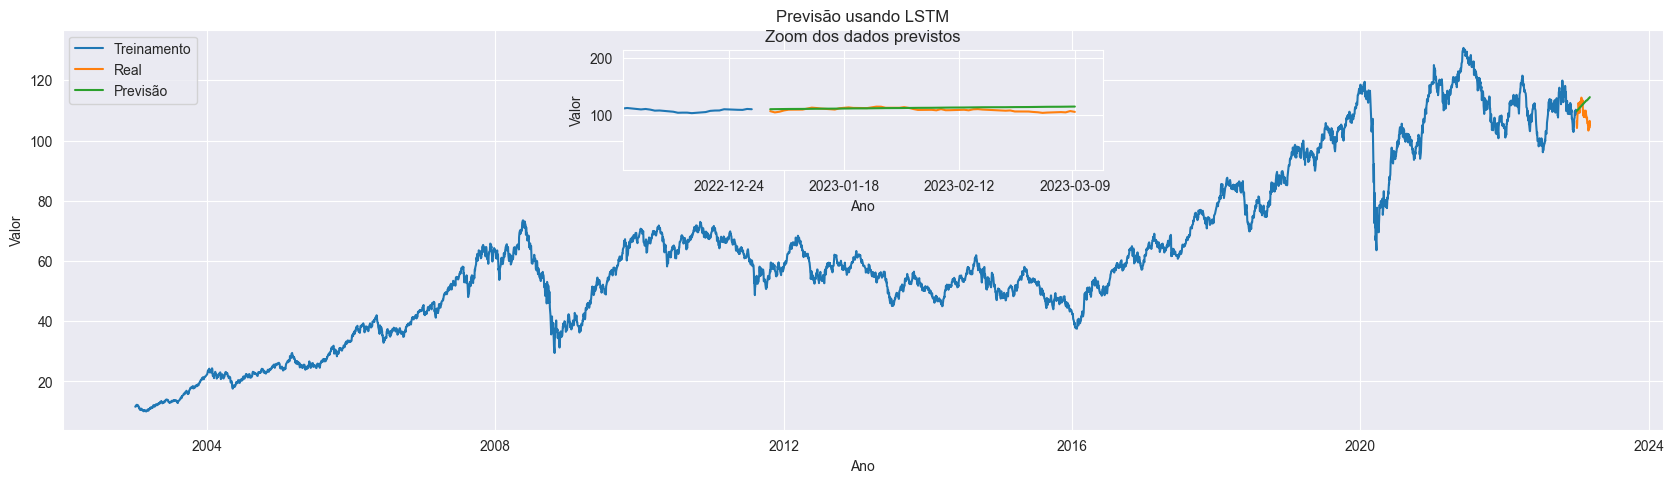

In [45]:
fig = plt.figure(figsize=(16, 4))
eixo = fig.add_axes([0, 0, 1, 1])
eixo.plot(train.index, train_data, label='Treinamento')
eixo.plot(test.index, test_data, label='Real')
eixo.plot(test.index, forecast_lstm, label='Previsão')
eixo.legend()
eixo.set_title('Previsão usando LSTM')
eixo.set_xlabel('Ano')
eixo.set_ylabel('Valor')
eixo2 = fig.add_axes([0.35, 0.65, 0.3, 0.3])
eixo2.plot(train.index, train_data)
eixo2.plot(test.index, test_data, label='Real') 
eixo2.plot(test.index, forecast_lstm, label='Previsão')
eixo2.set_xlim(pd.Timestamp('2022-12-01'), pd.Timestamp('2023-03-15')) # type: ignore
eixo2.set_ylim(min(min(test_data), min(forecast_lstm)) - 100, max(max(test_data), max(forecast_lstm)) + 100)
eixo2.set_title('Zoom dos dados previstos')
eixo2.set_xlabel('Ano')
eixo2.set_ylabel('Valor')
eixo2.xaxis.set_major_locator(plt.MaxNLocator(5)) # type: ignore
plt.show()

In [47]:
model_names = ['Naive', 'SeasonalNaive', 'SeasWA', 'WindowAverage', 'RWD', 'HistoricAverage',
               'SES', 'SESOpt', 'SeasonalES', 'SeasESOpt', 'Holt', 'HoltWinters', 'ADIDA',
               'CrostonClassic', 'CrostonOptimized', 'CrostonSBA', 'IMAPA', 'TSB', 'MSTL',
               'DynamicOptimizedTheta', 'GARCH', 'ARCH', 'AutoARIMA', 'AutoETS',
               'CES', 'AutoTheta', 'Sarima', 'LSTM']

mape_errors = [
    mape_error(forecast['y'].values, forecast['Naive'].values),
    mape_error(forecast['y'].values, forecast['SeasonalNaive'].values),
    mape_error(forecast['y'].values, forecast['SeasWA'].values),
    mape_error(forecast['y'].values, forecast['WindowAverage'].values),
    mape_error(forecast['y'].values, forecast['RWD'].values),
    mape_error(forecast['y'].values, forecast['HistoricAverage'].values),
    mape_error(forecast['y'].values, forecast['SES'].values),
    mape_error(forecast['y'].values, forecast['SESOpt'].values),
    mape_error(forecast['y'].values, forecast['SeasonalES'].values),
    mape_error(forecast['y'].values, forecast['SeasESOpt'].values),
    mape_error(forecast['y'].values, forecast['Holt'].values),
    mape_error(forecast['y'].values, forecast['HoltWinters'].values),
    mape_error(forecast['y'].values, forecast['ADIDA'].values),
    mape_error(forecast['y'].values, forecast['CrostonClassic'].values),
    mape_error(forecast['y'].values, forecast['CrostonOptimized'].values),
    mape_error(forecast['y'].values, forecast['CrostonSBA'].values),
    mape_error(forecast['y'].values, forecast['IMAPA'].values),
    mape_error(forecast['y'].values, forecast['TSB'].values),
    mape_error(forecast['y'].values, forecast['MSTL'].values),
    mape_error(forecast['y'].values, forecast['DynamicOptimizedTheta'].values),
    mape_error(forecast['y'].values, forecast['GARCH(10,1)'].values),
    mape_error(forecast['y'].values, forecast['ARCH(10)'].values),
    mape_error(forecast['y'].values, forecast['AutoARIMA'].values),
    mape_error(forecast['y'].values, forecast['AutoETS'].values),
    mape_error(forecast['y'].values, forecast['CES'].values),
    mape_error(forecast['y'].values, forecast['AutoTheta'].values),
    mape_error(test['y'].values, sarima_forecast_result.values),
    mape_error(test['y'].values, forecast_lstm_values)
]
wmape_errors = [
    wmape_error(forecast['y'].values, forecast['Naive'].values),
    wmape_error(forecast['y'].values, forecast['SeasonalNaive'].values),
    wmape_error(forecast['y'].values, forecast['SeasWA'].values),
    wmape_error(forecast['y'].values, forecast['WindowAverage'].values),
    wmape_error(forecast['y'].values, forecast['RWD'].values),
    wmape_error(forecast['y'].values, forecast['HistoricAverage'].values),
    wmape_error(forecast['y'].values, forecast['SES'].values),
    wmape_error(forecast['y'].values, forecast['SESOpt'].values),
    wmape_error(forecast['y'].values, forecast['SeasonalES'].values),
    wmape_error(forecast['y'].values, forecast['SeasESOpt'].values),
    wmape_error(forecast['y'].values, forecast['Holt'].values),
    wmape_error(forecast['y'].values, forecast['HoltWinters'].values),
    wmape_error(forecast['y'].values, forecast['ADIDA'].values),
    wmape_error(forecast['y'].values, forecast['CrostonClassic'].values),
    wmape_error(forecast['y'].values, forecast['CrostonOptimized'].values),
    wmape_error(forecast['y'].values, forecast['CrostonSBA'].values),
    wmape_error(forecast['y'].values, forecast['IMAPA'].values),
    wmape_error(forecast['y'].values, forecast['TSB'].values),
    wmape_error(forecast['y'].values, forecast['MSTL'].values),
    wmape_error(forecast['y'].values, forecast['DynamicOptimizedTheta'].values),
    wmape_error(forecast['y'].values, forecast['GARCH(10,1)'].values),
    wmape_error(forecast['y'].values, forecast['ARCH(10)'].values),
    wmape_error(forecast['y'].values, forecast['AutoARIMA'].values),
    wmape_error(forecast['y'].values, forecast['AutoETS'].values),
    wmape_error(forecast['y'].values, forecast['CES'].values),
    wmape_error(forecast['y'].values, forecast['AutoTheta'].values),
    wmape_error(test['y'].values, sarima_forecast_result.values),
    wmape_error(test['y'].values, forecast_lstm_values)
]

smape_errors = [
    smape_error(forecast['y'].values, forecast['Naive'].values),
    smape_error(forecast['y'].values, forecast['SeasonalNaive'].values),
    smape_error(forecast['y'].values, forecast['SeasWA'].values),
    smape_error(forecast['y'].values, forecast['WindowAverage'].values),
    smape_error(forecast['y'].values, forecast['RWD'].values),
    smape_error(forecast['y'].values, forecast['HistoricAverage'].values),
    smape_error(forecast['y'].values, forecast['SES'].values),
    smape_error(forecast['y'].values, forecast['SESOpt'].values),
    smape_error(forecast['y'].values, forecast['SeasonalES'].values),
    smape_error(forecast['y'].values, forecast['SeasESOpt'].values),
    smape_error(forecast['y'].values, forecast['Holt'].values),
    smape_error(forecast['y'].values, forecast['HoltWinters'].values),
    smape_error(forecast['y'].values, forecast['ADIDA'].values),
    smape_error(forecast['y'].values, forecast['CrostonClassic'].values),
    smape_error(forecast['y'].values, forecast['CrostonOptimized'].values),
    smape_error(forecast['y'].values, forecast['CrostonSBA'].values),
    smape_error(forecast['y'].values, forecast['IMAPA'].values),
    smape_error(forecast['y'].values, forecast['TSB'].values),
    smape_error(forecast['y'].values, forecast['MSTL'].values),
    smape_error(forecast['y'].values, forecast['DynamicOptimizedTheta'].values),
    smape_error(forecast['y'].values, forecast['GARCH(10,1)'].values),
    smape_error(forecast['y'].values, forecast['ARCH(10)'].values),
    smape_error(forecast['y'].values, forecast['AutoARIMA'].values),
    smape_error(forecast['y'].values, forecast['AutoETS'].values),
    smape_error(forecast['y'].values, forecast['CES'].values),
    smape_error(forecast['y'].values, forecast['AutoTheta'].values),
    smape_error(test['y'].values, sarima_forecast_result.values),
    smape_error(test['y'].values, forecast_lstm_values) 
]

df_error = pd.DataFrame({'model': model_names, 'mape': mape_errors, 'wmape': wmape_errors, 'smape': smape_errors})

MAPE (Mean Absolute Percentage Error): 2.00%
MAPE (Mean Absolute Percentage Error): 2.05%
MAPE (Mean Absolute Percentage Error): 2.87%
MAPE (Mean Absolute Percentage Error): 1.98%
MAPE (Mean Absolute Percentage Error): 2.00%
MAPE (Mean Absolute Percentage Error): 43.88%
MAPE (Mean Absolute Percentage Error): 17.81%
MAPE (Mean Absolute Percentage Error): 2.00%
MAPE (Mean Absolute Percentage Error): 56.75%
MAPE (Mean Absolute Percentage Error): 2.15%
MAPE (Mean Absolute Percentage Error): 2.02%
MAPE (Mean Absolute Percentage Error): 1.98%
MAPE (Mean Absolute Percentage Error): 2.09%
MAPE (Mean Absolute Percentage Error): 2.39%
MAPE (Mean Absolute Percentage Error): 2.09%
MAPE (Mean Absolute Percentage Error): 6.70%
MAPE (Mean Absolute Percentage Error): 2.09%
MAPE (Mean Absolute Percentage Error): 1.99%
MAPE (Mean Absolute Percentage Error): 2.16%
MAPE (Mean Absolute Percentage Error): 1.99%
MAPE (Mean Absolute Percentage Error): 103.59%
MAPE (Mean Absolute Percentage Error): 103.58%
MAP

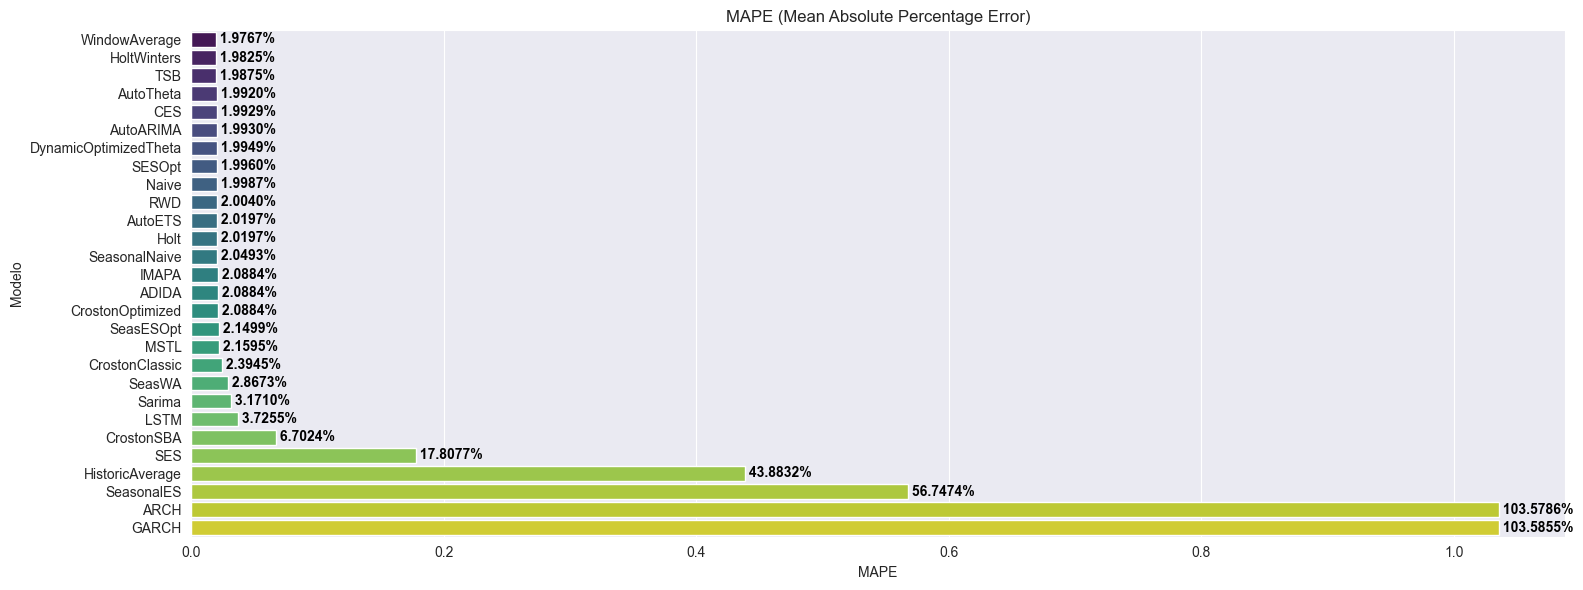

In [48]:
df_sorted = df_error.sort_values(by='mape')
plt.figure(figsize=(16, 6))
sns.barplot(x='mape', y='model', data=df_sorted, palette='viridis')
plt.title("MAPE (Mean Absolute Percentage Error)")
plt.xlabel("MAPE")
plt.ylabel("Modelo")

for index, value in enumerate(df_sorted['mape']):
    plt.text(value, index, f' {value:.4%}', va='center', fontsize=10, color='black', fontweight='bold')

plt.tight_layout()
plt.show()

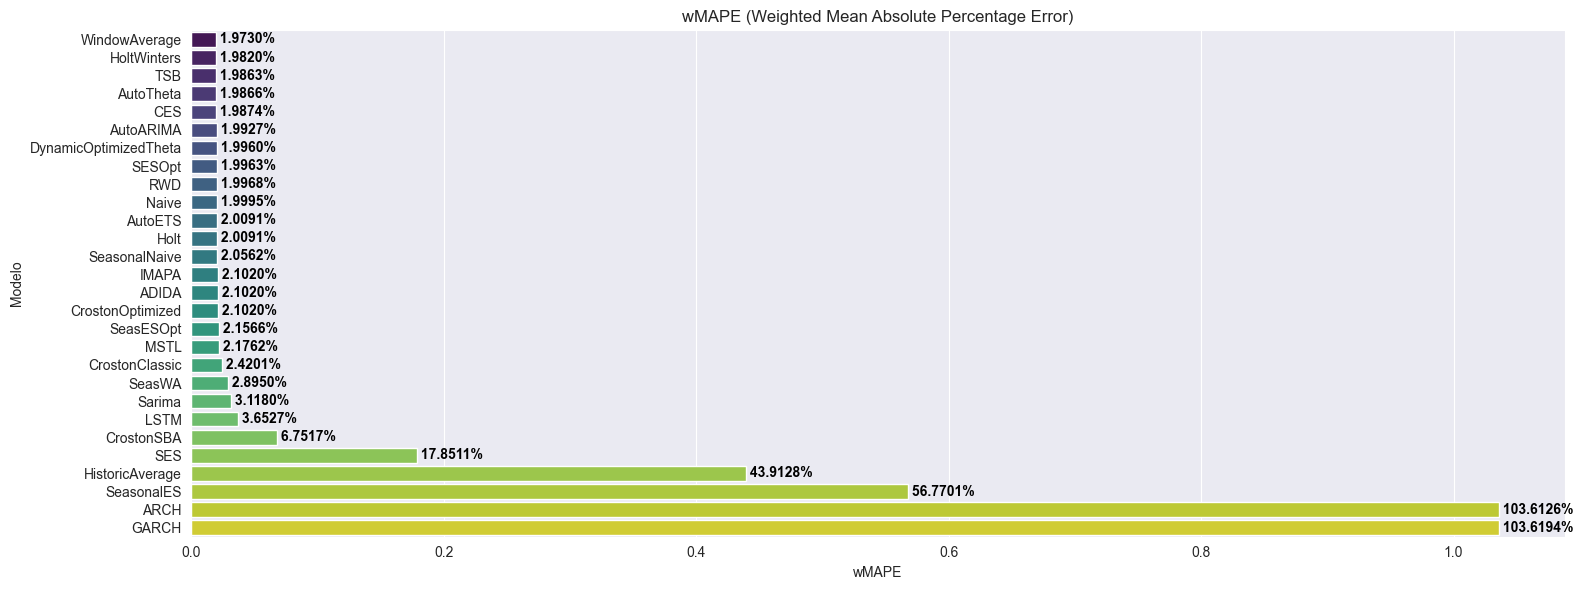

In [49]:
df_sorted = df_error.sort_values(by='wmape')
plt.figure(figsize=(16, 6))
sns.barplot(x='wmape', y='model', data=df_sorted, palette='viridis')
plt.title("wMAPE (Weighted Mean Absolute Percentage Error)")
plt.xlabel("wMAPE")
plt.ylabel("Modelo")

for index, value in enumerate(df_sorted['wmape']):
    plt.text(value, index, f' {value:.4%}', va='center', fontsize=10, color='black', fontweight='bold')

plt.tight_layout()
plt.show()

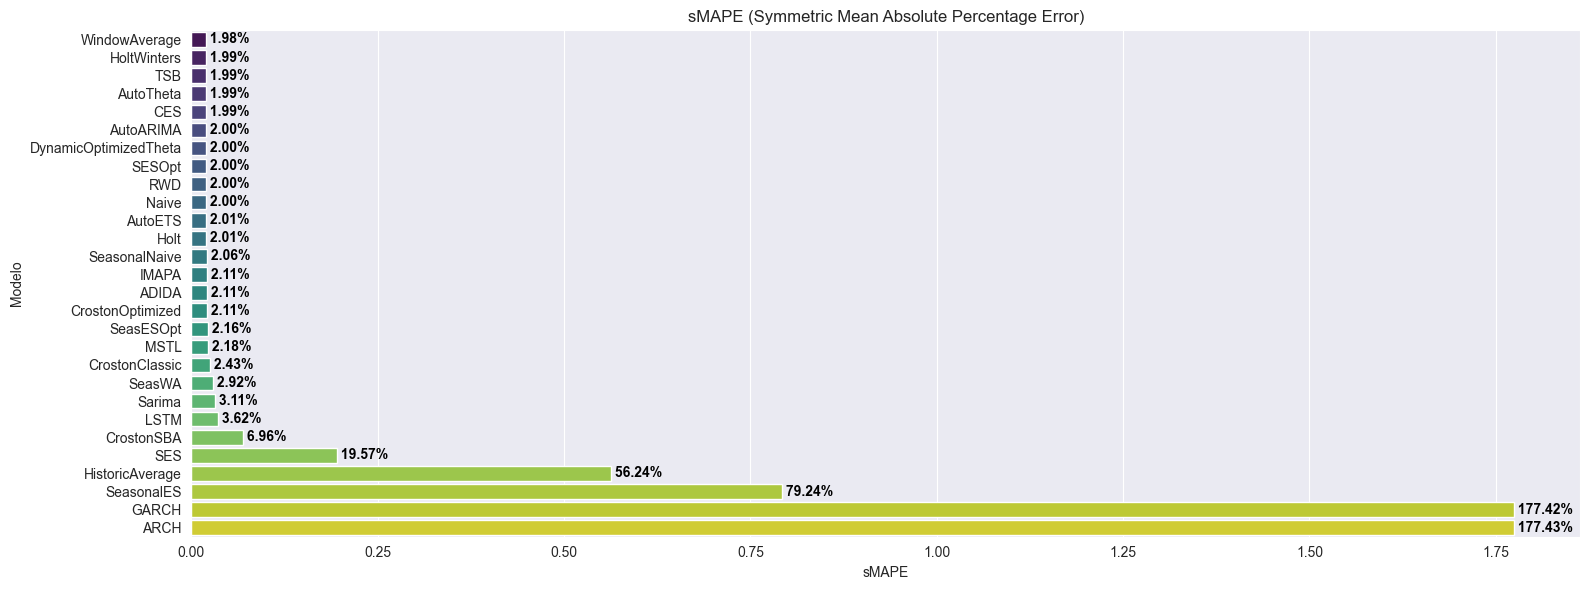

In [50]:
df_sorted = df_error.sort_values(by='smape')
plt.figure(figsize=(16, 6))
sns.barplot(x='smape', y='model', data=df_sorted, palette='viridis')
plt.title("sMAPE (Symmetric Mean Absolute Percentage Error)")
plt.xlabel("sMAPE")
plt.ylabel("Modelo")

for index, value in enumerate(df_sorted['smape']):
    plt.text(value, index, f' {value:.2%}', va='center', fontsize=10, color='black', fontweight='bold')

plt.tight_layout()
plt.show()